# QF 627 Group 1:
**1. HE YIHAO**

**2. VO VAN QUOC TOAN**

**3. SEAH YAN DE BRYAN**

**4. CHANG TING YU**

**5. QU WENQIN**

# Report Contents:

### [Part 1: Introduction](#Introduction)
### [Part 2: Strategies](#Strategies)
### [Part 3: Best Performers](#BestPerformance)
###        [A: LogisticRegression_lag14](#lag14)
###        [B: ML+LogisticRegression](#logreg2)
###        [C: Momentum_35_85](#momentum)
### [Part 4: Analysis and Recommendations](#Analysis)
### [Part 5: Contribution Statement](#Contribution)

# Part 1: Introduction
<a id="Introduction"></a>

As can be seen from the reports contents above, this report is structured into 5 parts. First, an introduction, where we give an overview of our methodology, as well as explicitly state some of the assumptions we had adopted. Second, our code itself, which we used to generate and backtest the various strategies. Third, a summary of the results from our 3 best performing strategies.Fourth, we discuss the insights and analysis we have derived from our project attempt. Fifth and finally - our contribution statement, as per the report requirements.

In attempting this project, we first started with the basic momentum, mean reversion and machine learning approaches covered in class, and then modified/optimised them to obtain better results. 

In doing so we made some key assumptions in line with the scope of this assignment. In particular, we assumed that we were allowed to use the full dataset in both our training and testing data for the machine learning strategies. Further, we also assumed that the commercial/practical feasibility of these strategies in an out of sample setting was irrelevant - we were only focused on optimising the in-sample performance of the key metrics.

# Part 2: Strategies
<a id="Strategies"></a>

## Preparation

### Setting Dependencies

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv, set_option
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas.plotting import scatter_matrix
import seaborn as sns

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

import scipy.optimize as opt
from scipy.stats import norm
from scipy.optimize import fmin
from scipy.optimize import minimize

from sklearn import linear_model    # 
import random   # random 

# feature engineering

from sklearn.preprocessing import StandardScaler

# split, cross-validation, tuning, grid_search

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# models (algos.)

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # multi-class

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.metrics import mean_squared_error


In [2]:
np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

### Performance Data Tracker

In [3]:
Performance_Tracker = pd.DataFrame(columns = ["StrategyName","SharpeRatio", "CAGR","MaxDrawdown","RemainingCapital"])

In [4]:
spy=pdr.get_data_yahoo('SPY',
                                  start = dt.datetime(2003,11,1),
                                  end = dt.datetime(2022,10,31))

In [5]:
spy["RETURNS"] = spy["Adj Close"].pct_change().dropna()

In [6]:
def sharperatio(returns):
    sharpe=np.sqrt(252)*(returns.mean()/returns.std())
    return sharpe

In [7]:
sharpe = sharperatio(spy["RETURNS"])

In [8]:
spy["CUMULATIVE_RETURNS"] = spy["RETURNS"].cumsum().apply(np.exp)
spy["MAX_GROSS_PERFORMANCE"] = spy["CUMULATIVE_RETURNS"].cummax()

In [9]:
D = (spy.index[-1] - spy.index[0]).days
CAGR = (((spy["CUMULATIVE_RETURNS"].tail(1)) ** (365.0/D)) - 1)[0]
CAGR

0.11184660573355742

In [10]:
DRAWDOWN = spy["MAX_GROSS_PERFORMANCE"] - spy["CUMULATIVE_RETURNS"]
MaxDrawdown = DRAWDOWN.max()

In [11]:
RemainingCapital = ((spy["CUMULATIVE_RETURNS"].tail(1) * 500000))[0]

In [12]:
Performance_Tracker.loc[0] = ["SPYBuyandHold",sharpe,CAGR,MaxDrawdown,RemainingCapital]

In [13]:
Performance_Tracker

,StrategyName,SharpeRatio,CAGR,MaxDrawdown,RemainingCapital
0,SPYBuyandHold,0.554807,0.111847,2.03744,3.753647e+06


In [14]:
Returns_Tracker = pd.DataFrame(spy["RETURNS"])

In [15]:
Returns_Tracker = Returns_Tracker.rename(columns = {"RETURNS":"SPYBuyandHold"})

## Strategies

### Mean Reversion (YH)

In [16]:
def obtain(stocks, start, end):
    def data(ticker):
        return(pdr.get_data_yahoo(ticker, 
                                  start = start,
                                  end = end)
              )
    
    stock_data = map(data, stocks)
    return(pd.concat(stock_data,
                     keys = stocks,
                     names = ["Ticker", "Date"]
                    )
           )

In [17]:
stocks = ["SPY"]
our_data = obtain(stocks,
         dt.datetime(2003, 11, 1),
         dt.datetime(2022, 10, 31)
                  )

In [18]:
def sample_first_prows(data, perc=0.7):
    return data.head(int(len(data)*(perc)))

In [19]:
def sharpe_generator(rolling_num):
    Daily_Close_Prices = our_data[["Adj Close"]].reset_index().pivot("Date",
                                                                     "Ticker",
                                                                     "Adj Close")

    rolling_num = int(rolling_num.round(0))
    Daily_Close_Prices['SMA_41'] = Daily_Close_Prices.SPY.rolling(rolling_num).mean()
    Daily_Close_Prices['DIST']  = Daily_Close_Prices['SPY'] - Daily_Close_Prices['SMA_41'] 

    
    Daily_Close_Prices = sample_first_prows(Daily_Close_Prices)
    
    T = 4
    
    Daily_Close_Prices["POS"] = np.where(Daily_Close_Prices["DIST"] > T,
                        -1, np.nan)
    Daily_Close_Prices["POS"] = np.where(Daily_Close_Prices["DIST"] < -T,
                        1, Daily_Close_Prices["POS"]
                        )
    Daily_Close_Prices["POS"] = np.where(Daily_Close_Prices["DIST"] * Daily_Close_Prices["DIST"].shift(1) < 0,
                        0, Daily_Close_Prices["POS"]
                        )
    Daily_Close_Prices["POS"] = Daily_Close_Prices["POS"].ffill()
    Daily_Close_Prices["POS"] = Daily_Close_Prices["POS"].fillna(0)


    Daily_Close_Prices['RETURNS'] = np.log(Daily_Close_Prices.SPY/Daily_Close_Prices.SPY.shift(1))


    Daily_Close_Prices['STRATEGY'] = Daily_Close_Prices['POS'].shift(1) * Daily_Close_Prices['RETURNS']
    Daily_Close_Prices["CUMULATIVE_RETURNS"] = Daily_Close_Prices["STRATEGY"].cumsum().apply(np.exp)
    Daily_Close_Prices["MAX_GROSS_PERFORMANCE"] = Daily_Close_Prices["CUMULATIVE_RETURNS"].cummax()

    Sharpe = (Daily_Close_Prices[["STRATEGY"]].mean()/Daily_Close_Prices[["STRATEGY"]].std())*math.sqrt(252)

    return Sharpe[0]

In [20]:
## calibration
def calibration_total(x):
  sharpe = sharpe_generator(x)
  return sharpe

solution_total = opt.minimize_scalar(lambda x: -calibration_total(x), bounds=[10,200], method='bounded')

optimized_strategy_share_total = solution_total.x.round(0)
print(optimized_strategy_share_total)

36.0


<AxesSubplot:xlabel='Date'>

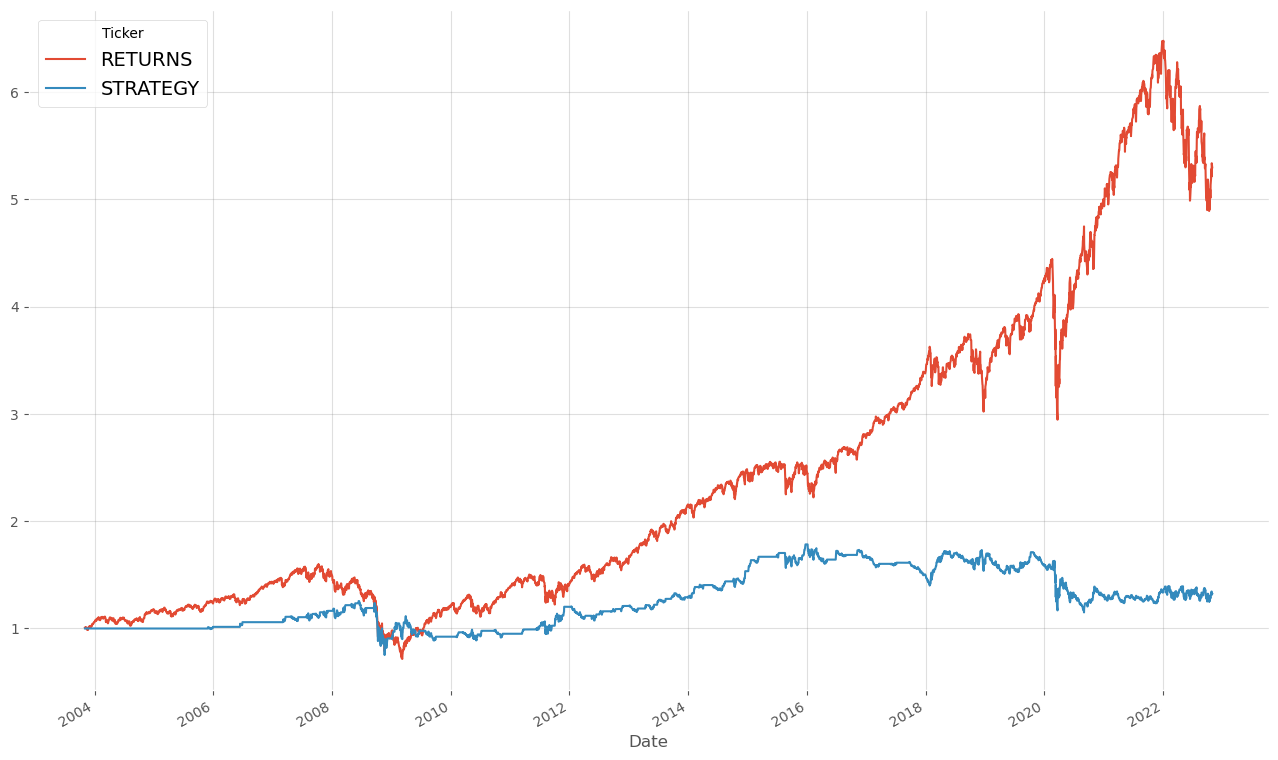

In [21]:
Daily_Close_Prices = our_data[["Adj Close"]].reset_index().pivot("Date",
                                                                 "Ticker",
                                                                 "Adj Close")

Daily_Close_Prices['SMA_41'] = Daily_Close_Prices.SPY.rolling(36).mean()
Daily_Close_Prices['DIST']  = Daily_Close_Prices['SPY'] - Daily_Close_Prices['SMA_41'] 


T = 4

Daily_Close_Prices["POS"] = np.where(Daily_Close_Prices["DIST"] > T,
                    -1, np.nan)
Daily_Close_Prices["POS"] = np.where(Daily_Close_Prices["DIST"] < -T,
                    1, Daily_Close_Prices["POS"]
                    )
Daily_Close_Prices["POS"] = np.where(Daily_Close_Prices["DIST"] * Daily_Close_Prices["DIST"].shift(1) < 0,
                    0, Daily_Close_Prices["POS"]
                    )
Daily_Close_Prices["POS"] = Daily_Close_Prices["POS"].ffill()
Daily_Close_Prices["POS"] = Daily_Close_Prices["POS"].fillna(0)


Daily_Close_Prices['RETURNS'] = np.log(Daily_Close_Prices.SPY/Daily_Close_Prices.SPY.shift(1))


Daily_Close_Prices['STRATEGY'] = Daily_Close_Prices['POS'].shift(1) * Daily_Close_Prices['RETURNS']
Daily_Close_Prices["CUMULATIVE_RETURNS"] = Daily_Close_Prices["STRATEGY"].cumsum().apply(np.exp)
Daily_Close_Prices["MAX_GROSS_PERFORMANCE"] = Daily_Close_Prices["CUMULATIVE_RETURNS"].cummax()

Daily_Close_Prices[['RETURNS','STRATEGY']].dropna().cumsum().apply(np.exp).plot(figsize = (16, 10) )



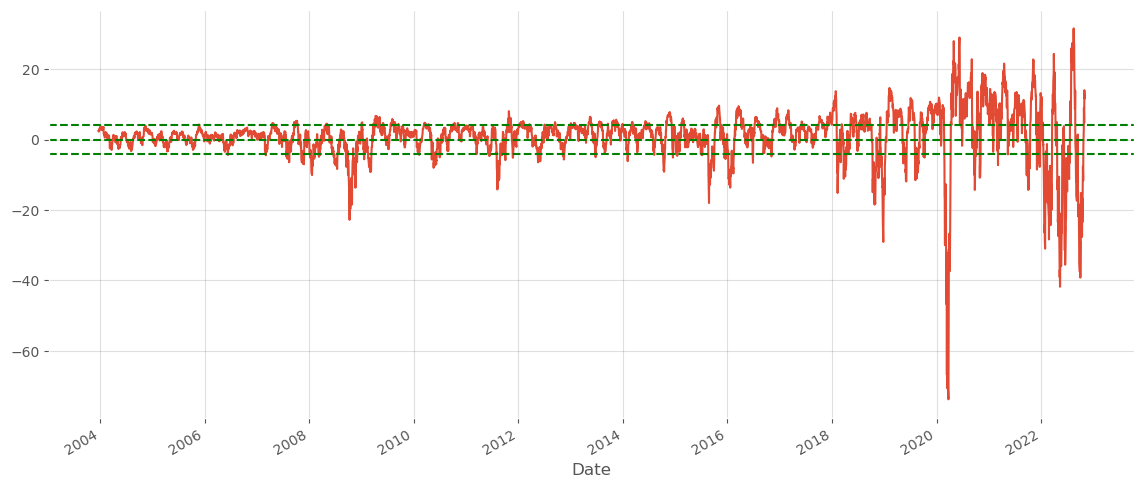

In [22]:
Daily_Close_Prices["DIST"].dropna().plot(figsize = (14, 6)
                        )

plt.axhline(T, color = "g", ls = "--")
plt.axhline(0, color = "g", ls = "--")
plt.axhline(-T, color = "g", ls = "--")


In [23]:
sharpe1 = sharperatio(Daily_Close_Prices['STRATEGY'])
sharpe1

0.08942457396849152

In [24]:
D = (Daily_Close_Prices.index[-1] - Daily_Close_Prices.index[0]).days
CAGR1 = (((Daily_Close_Prices[['STRATEGY']].cumsum().apply(np.exp).tail(1).values[0][0]) / (1)) ** (365.0/D)) - 1
CAGR1

0.014824431074482947

<AxesSubplot:xlabel='Date'>

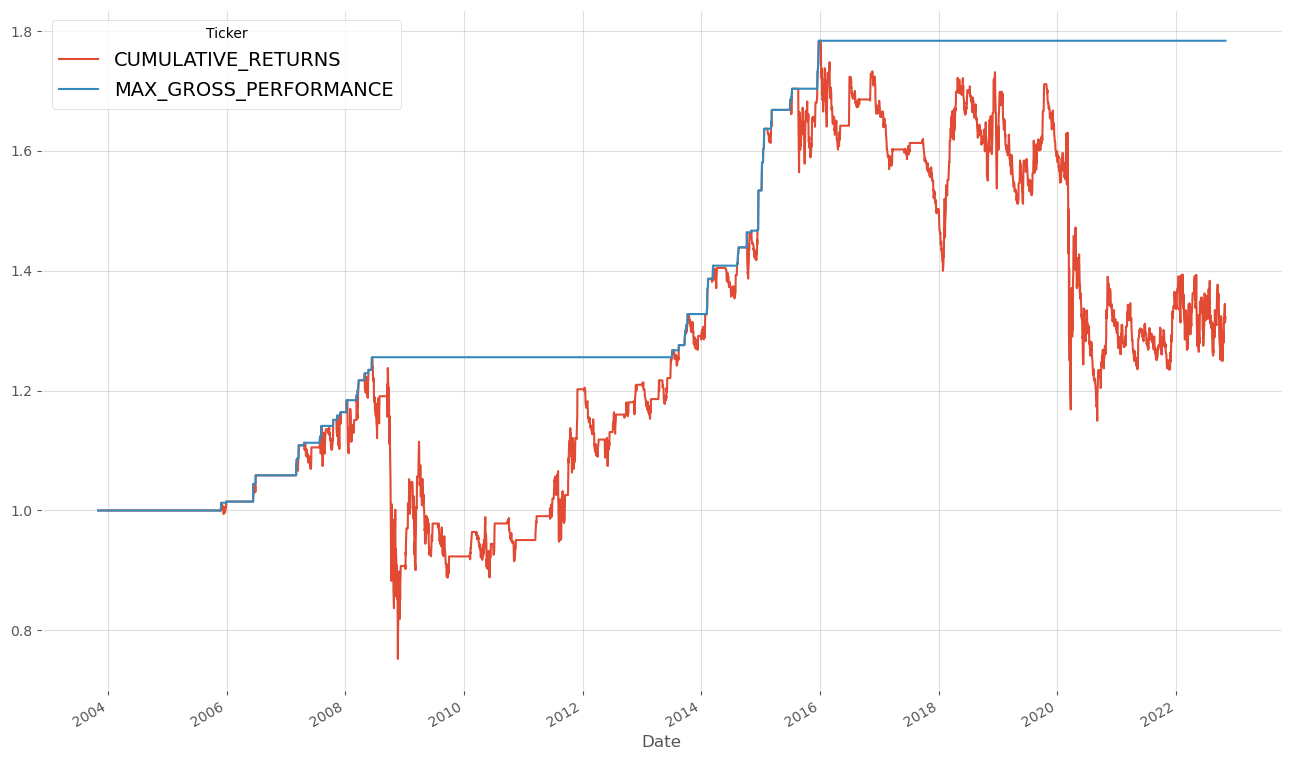

In [25]:

Daily_Close_Prices[['CUMULATIVE_RETURNS','MAX_GROSS_PERFORMANCE']].plot(figsize = (16, 10) )

In [26]:
DRAWDOWN = Daily_Close_Prices["MAX_GROSS_PERFORMANCE"] - Daily_Close_Prices["CUMULATIVE_RETURNS"]
MaxDrawdown1 = DRAWDOWN.max()

In [27]:
PERIOD = (DRAWDOWN[DRAWDOWN == 0].index[1:].to_pydatetime() - 
          DRAWDOWN[DRAWDOWN == 0].index[:-1].to_pydatetime()
          )
PERIOD.max()

datetime.timedelta(days=1845)

In [28]:
RemainingCapital1 = ((Daily_Close_Prices[['STRATEGY']].cumsum().apply(np.exp) * 500000).tail(1)).values[0][0]

In [29]:
RemainingCapital1

661431.564715892

In [30]:
Performance_Tracker.loc[1] = ["MeanReversion_41",sharpe1,CAGR1,MaxDrawdown1,RemainingCapital1]

### Momentum (TY)
<a id="momentum"></a>

In [31]:
def f(params):
    
    fast,slow = params
    
    Daily_Close_Prices = our_data[["Adj Close"]].reset_index().pivot("Date",
                                                                     "Ticker",
                                                                     "Adj Close")

    fast = int(fast.round(0))
    slow = int(slow.round(0))
    
    Daily_Close_Prices["SMA_20"] = Daily_Close_Prices[["SPY"]].rolling(window = fast).mean()
    Daily_Close_Prices["SMA_60"]= Daily_Close_Prices[["SPY"]].rolling(window = slow).mean()
    Daily_Close_Prices['RETURNS'] = np.log(Daily_Close_Prices.SPY/Daily_Close_Prices.SPY.shift(1))

    Daily_Close_Prices["Trading_Positions"] = np.where(Daily_Close_Prices["SMA_20"] < 
                                                   Daily_Close_Prices["SMA_60"],
                                                   -1 , 1)

    Daily_Close_Prices['STRATEGY'] = Daily_Close_Prices['Trading_Positions'].shift(1) * Daily_Close_Prices['RETURNS']
    Daily_Close_Prices["CUMULATIVE_RETURNS"] = Daily_Close_Prices["STRATEGY"].cumsum().apply(np.exp)
    Daily_Close_Prices["MAX_GROSS_PERFORMANCE"] = Daily_Close_Prices["CUMULATIVE_RETURNS"].cummax()

    Sharpe = (Daily_Close_Prices[["STRATEGY"]].mean()/Daily_Close_Prices[["STRATEGY"]].std())*math.sqrt(252)

    return -Sharpe[0]

In [32]:

x0=[30,100]

optimum = minimize(f, x0,method="Nelder-Mead" )
best_fast = optimum.x[0]
best_slow = optimum.x[1]

In [33]:
best_fast

35.625

In [34]:
best_slow

85.0

<AxesSubplot:xlabel='Date'>

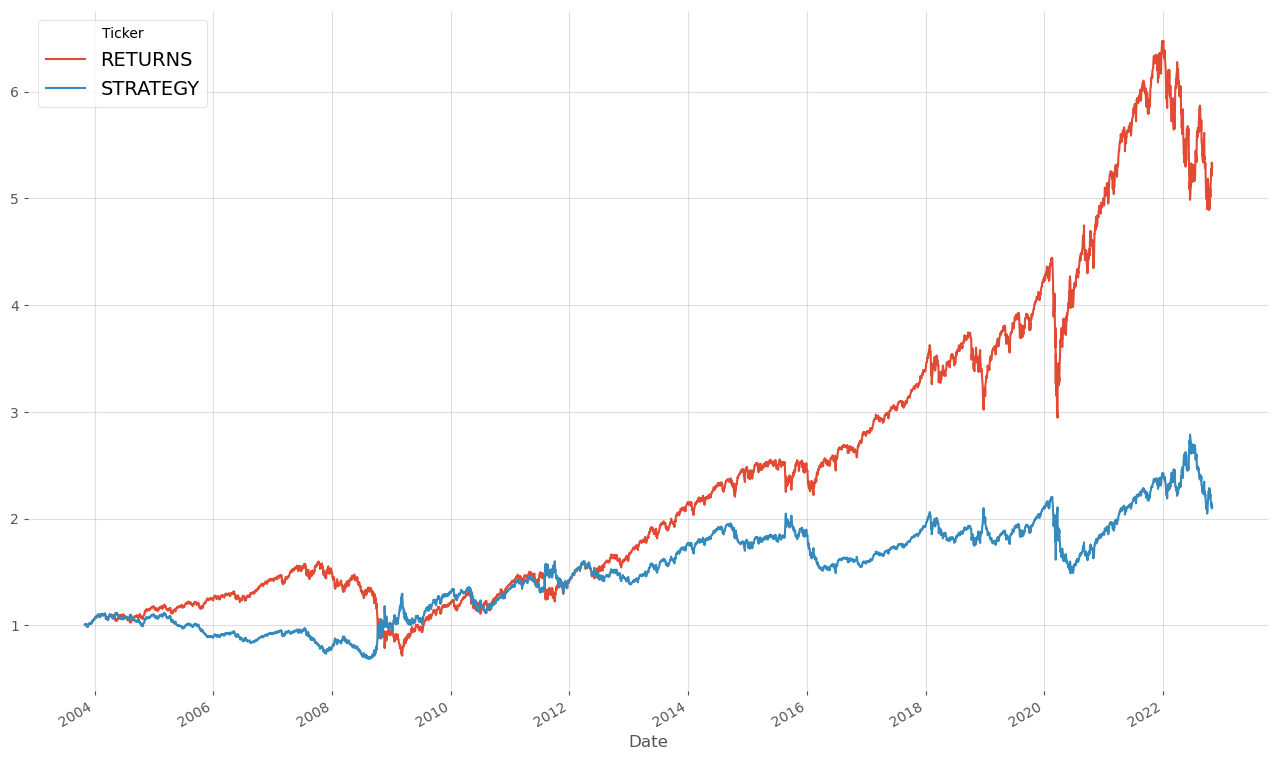

In [35]:
Daily_Close_Prices = our_data[["Adj Close"]].reset_index().pivot("Date",
                                                                 "Ticker",
                                                                 "Adj Close")

fast = int(best_fast.round(0))
slow = int(best_slow.round(0))

Daily_Close_Prices["SMA_20"] = Daily_Close_Prices[["SPY"]].rolling(window = fast).mean()
Daily_Close_Prices["SMA_60"]= Daily_Close_Prices[["SPY"]].rolling(window = slow).mean()
Daily_Close_Prices['RETURNS'] = np.log(Daily_Close_Prices.SPY/Daily_Close_Prices.SPY.shift(1))

Daily_Close_Prices["Trading_Positions"] = np.where(Daily_Close_Prices["SMA_20"] < 
                                               Daily_Close_Prices["SMA_60"],
                                               -1 , 1)

Daily_Close_Prices['STRATEGY'] = Daily_Close_Prices['Trading_Positions'].shift(1) * Daily_Close_Prices['RETURNS']
Daily_Close_Prices["CUMULATIVE_RETURNS"] = Daily_Close_Prices["STRATEGY"].cumsum().apply(np.exp)
Daily_Close_Prices["MAX_GROSS_PERFORMANCE"] = Daily_Close_Prices["CUMULATIVE_RETURNS"].cummax()

Daily_Close_Prices[['RETURNS','STRATEGY']].dropna().cumsum().apply(np.exp).plot(figsize = (16, 10) )



In [36]:
sharpe2 = sharperatio(Daily_Close_Prices[["STRATEGY"]])[0]
sharpe2

0.20523726207120935

In [37]:
D = (Daily_Close_Prices.index[-1] - Daily_Close_Prices.index[0]).days
CAGR2 = (((Daily_Close_Prices[['STRATEGY']].cumsum().apply(np.exp).tail(1).values[0][0]) / (1)) ** (365.0/D)) - 1
CAGR2

0.0400661355896299

<AxesSubplot:xlabel='Date'>

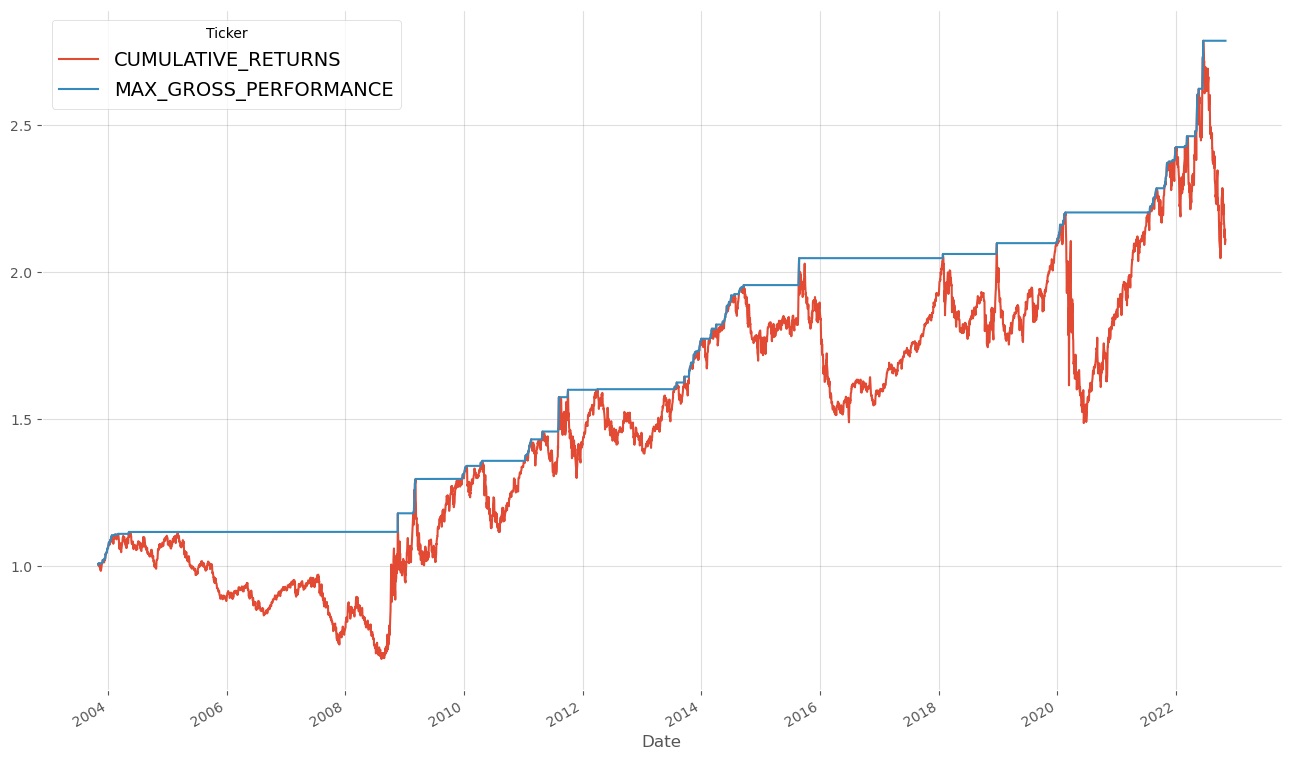

In [38]:

Daily_Close_Prices[['CUMULATIVE_RETURNS','MAX_GROSS_PERFORMANCE']].plot(figsize = (16, 10) )

In [39]:
DRAWDOWN = Daily_Close_Prices["MAX_GROSS_PERFORMANCE"] - Daily_Close_Prices["CUMULATIVE_RETURNS"]
MaxDrawdown2 = DRAWDOWN.max()
MaxDrawdown2

0.7391776256552323

In [40]:
PERIOD = (DRAWDOWN[DRAWDOWN == 0].index[1:].to_pydatetime() - 
          DRAWDOWN[DRAWDOWN == 0].index[:-1].to_pydatetime()
          )
PERIOD.max()

datetime.timedelta(days=1354)

In [41]:
RemainingCapital2 = ((Daily_Close_Prices[['STRATEGY']].cumsum().apply(np.exp) * 500000).tail(1)).values[0][0]
RemainingCapital2

1055265.8423157698

In [42]:
Performance_Tracker.loc[2] = ["Momentum_35_85",sharpe2,CAGR2,MaxDrawdown2,RemainingCapital2]

### Mean Reversion + Random Forest (WQ)

In [43]:
X0 = np.log(spy.loc[:, ("Adj Close","Low","High")])
X0.head()

,Adj Close,Low,High
Date,,,
2003-10-31,4.289131,4.656053,4.660983
2003-11-03,4.295662,4.660699,4.669177
2003-11-04,4.293490,4.659469,4.665983
2003-11-05,4.294246,4.653008,4.663156
2003-11-06,4.299523,4.654912,4.667581


In [44]:
X0.shape

(4783, 3)

In [45]:
X0["SMA_42"] = X0["Adj Close"].rolling(window = 42).mean()

T = 2 * X0["Adj Close"].rolling(window = 42).std()

X0["DIST"] = X0["Adj Close"] - X0["SMA_42"]


X0["POS"] = np.where(X0["DIST"] > T, -1, np.nan)

X0["POS"] = np.where(X0["DIST"] < -T, 1, X0["POS"])

X0["POS"] = np.where(X0["DIST"] * X0["DIST"].shift(1) < 0,
                    0, X0["POS"]  # HOLD
                    )

In [46]:
def EMA(df, n):
    EMA = pd.Series(df["Adj Close"].ewm(span = n,
                                    min_periods = n).mean(),
                    name = "EMA_" + str(n)
                    )
    return EMA

In [47]:
def MA(df, n):
    MA = pd.Series(df["Adj Close"].rolling(n, min_periods=n).mean(), name="MA_" + str(n))
    return MA

# Rate of Change (RoC)

def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series((M / N) * 100, 
                    name = "ROC_" + str(n)    
                    )
    return ROC

def MOM(df, n):
    MOM = pd.Series(df.diff(n),
                    name = "MOM_" + str(n)
                   )
    return MOM

# RSI 

def RSI(series, period):
    
    delta = series.diff().dropna()
    
    u = delta * 0
    d = u.copy()
    
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    
    u[u.index[period - 1]] = np.mean( u[:period] ) # 
    
    u = u.drop(u.index[:(period - 1)
                      ]
              )
    
    d[d.index[period - 1]] = np.mean( d[:period] )
    
    d = d.drop(d.index[:(period - 1)
                      ]
              )
    
    rs = u.ewm(com = period - 1, adjust = False).mean() / \
         d.ewm(com = period - 1, adjust = False).mean()
    
    return 100 - 100 / (1 + rs)

# Stochastic Oscillator 

def STOK(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / \
            (high.rolling(n).max() - low.rolling(n).min()
            )
           ) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / \
            (high.rolling(n).max() - low.rolling(n).min()
            )
           ) * 100
    
    STOD = STOK.rolling(3).mean()
    return STOD

In [48]:
# Moving Average

X0["MA21"] = MA(X0, 21)
X0["MA63"] = MA(X0, 63)
X0["MA252"] = MA(X0, 252)

#############################
# Exponential Moving Average

X0["EMA10"] = EMA(X0, 10)
X0["EMA30"] = EMA(X0, 30)
X0["EMA200"] = EMA(X0, 200)

#############################
# RSI 

X0["RSI10"] = RSI(X0["Adj Close"], 10)
X0["RSI30"] = RSI(X0["Adj Close"], 30)
X0["RSI200"] = RSI(X0["Adj Close"], 200)

#############################
# Stochastic Oscillator 

X0["%K10"] = STOK(X0["Adj Close"], X0["Low"], X0["High"], 10)
X0["%D10"] = STOD(X0["Adj Close"], X0["Low"], X0["High"], 10)

X0["%K30"] = STOK(X0["Adj Close"], X0["Low"], X0["High"], 30)
X0["%D30"] = STOD(X0["Adj Close"], X0["Low"], X0["High"], 30)

X0["%K200"] = STOK(X0["Adj Close"], X0["Low"], X0["High"], 200)
X0["%D200"] = STOD(X0["Adj Close"], X0["Low"], X0["High"], 200)

#############################
# Rate of Change (RoC)

X0["ROC10"] = ROC(X0["Adj Close"], 10)
X0["ROC30"] = ROC(X0["Adj Close"], 30)

X0.iloc[:, 4:] .head()

# Price Momentum

X0["MOM10"] = MOM(X0["Adj Close"], 10)
X0["MOM30"] = MOM(X0["Adj Close"], 30)

In [49]:
X0.head(100)

,Adj Close,Low,High,SMA_42,DIST,POS,MA21,MA63,MA252,EMA10,...,%K10,%D10,%K30,%D30,%K200,%D200,ROC10,ROC30,MOM10,MOM30
Date,,,,,,,,,,,,,,,,,,,,,
2003-10-31,4.289131,4.656053,4.660983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-11-03,4.295662,4.660699,4.669177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-11-04,4.293490,4.659469,4.665983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-11-05,4.294246,4.653008,4.663156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-11-06,4.299523,4.654912,4.667581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-03-19,4.350601,4.709891,4.723575,4.375942,-0.025341,1.0,4.373407,4.368368,NaN,4.362377,...,-703.255076,-660.794126,-664.105036,-646.389375,NaN,NaN,-0.707831,-0.606971,-0.043291,-0.015409
2004-03-22,4.337825,4.692265,4.705649,4.374870,-0.037046,1.0,4.371355,4.368488,NaN,4.357913,...,-650.448714,-664.339946,-508.868591,-603.419452,NaN,NaN,-0.908743,-0.904803,-0.043791,-0.039345
2004-03-23,4.336090,4.694645,4.704110,4.373819,-0.037729,1.0,4.369341,4.368625,NaN,4.353945,...,-702.996523,-685.566771,-511.358656,-561.444094,NaN,NaN,-0.564245,-1.017385,-0.041516,-0.041342


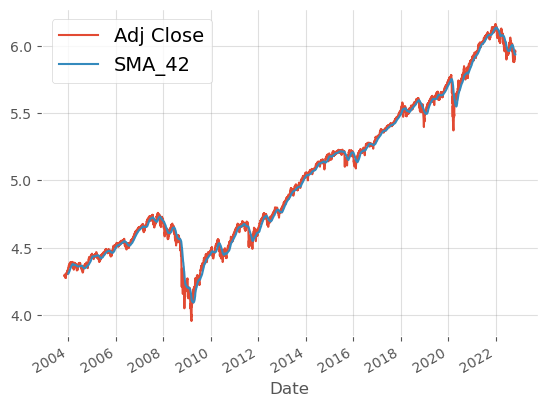

In [50]:
X0[["Adj Close","SMA_42"]
       ].plot()

plt.show()

In [51]:
X0 = X0.drop(["High", "Low", "SMA_42","DIST"],
                       axis = 1
                      ) # note the axis 

In [52]:
X0 = X0.dropna(axis = 0) # note the axis

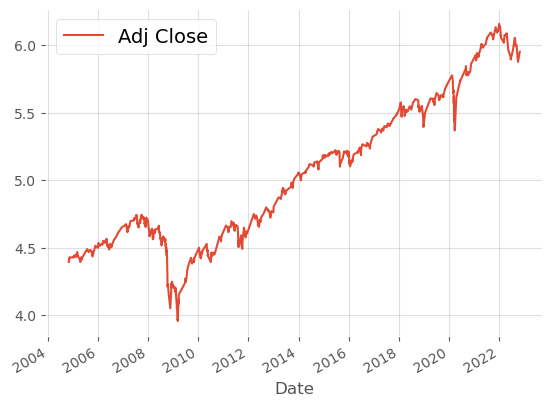

In [53]:
X0[["Adj Close"]
       ].plot()

plt.show()

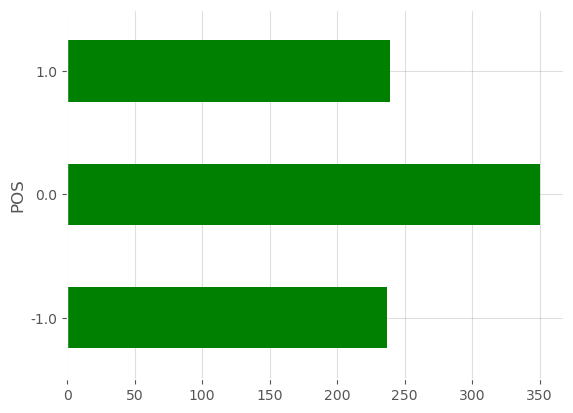

In [54]:
fig = plt.figure()

plot = X0.groupby(["POS"]).size().plot(kind = "barh", color = "green")

plt.show()

In [55]:
subset_dataset = X0.iloc[:]

Y = subset_dataset["POS"]

X = subset_dataset.loc[:, X0.columns != "POS"]

validation_size = 0.2

seed = 1

X_train, X_validation, Y_train, Y_validation = train_test_split(X, 
                                                                Y, 
                                                                test_size = validation_size, 
                                                                random_state = 1)

In [56]:
# test options for classification
num_folds = 10
seed = 7
scoring = "accuracy"
# scoring = "precision"
# scoring = "recall"
# scoring ="neg_log_loss"
# scoring = "roc_auc"

In [57]:
# spot check the algorithms

models = []

models.append(("LR", LogisticRegression(n_jobs = -1)
              )
             )

models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))

#Neural Network
models.append(("NN", MLPClassifier()))

# Ensable Models 

# Boosting methods
models.append(("AB", AdaBoostClassifier()))
models.append(("GBM", GradientBoostingClassifier()))

# Bagging methods
models.append(("RF", RandomForestClassifier(n_jobs = -1)
              )
             )

In [58]:
results = []

names = []

for name, model in models:
    kfold = KFold(n_splits = num_folds, 
                  random_state = seed, 
                  shuffle = True)
    cv_results = cross_val_score(model, 
                                 X_train, 
                                 Y_train, 
                                 cv = kfold, 
                                 scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.951515 (0.022268)
LDA: 0.978788 (0.016872)
KNN: 0.731818 (0.040684)
CART: 0.969697 (0.022473)
NB: 0.956061 (0.020830)
NN: 0.860606 (0.038807)
AB: 0.707576 (0.062121)
GBM: 0.974242 (0.013636)
RF: 0.983333 (0.019697)


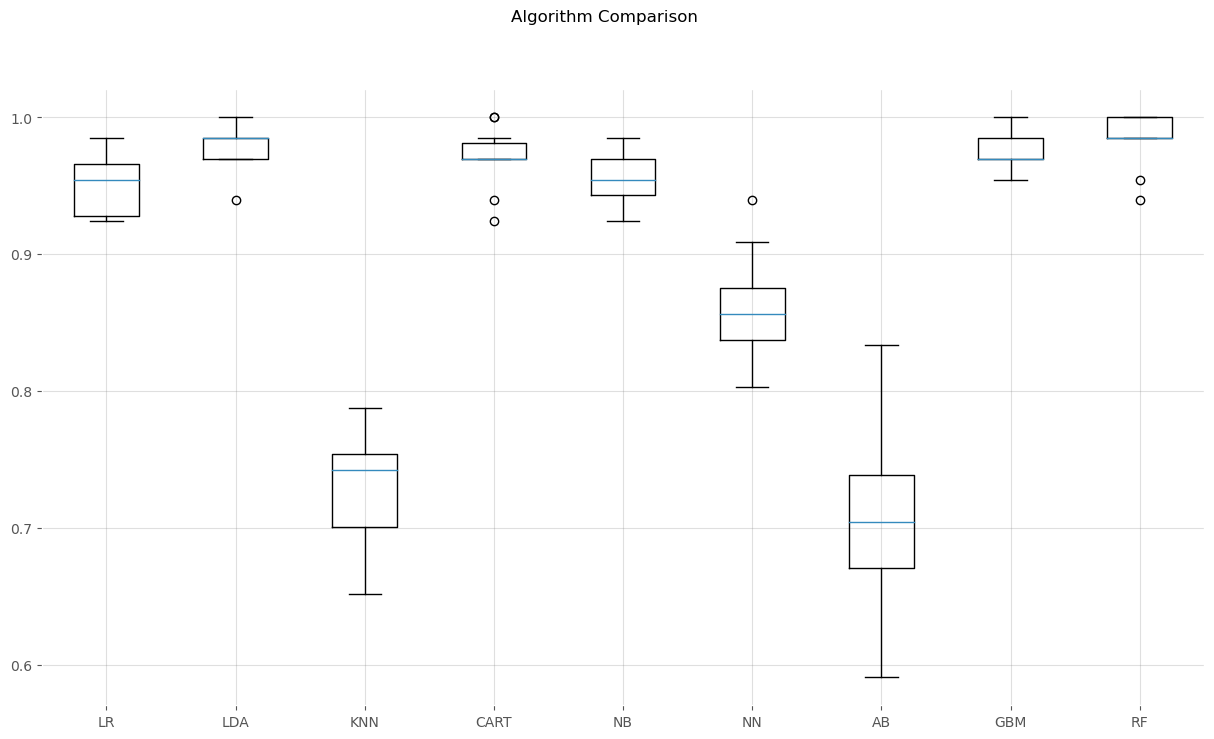

In [59]:
fig = plt.figure()
fig.suptitle("Algorithm Comparison")

ax = fig.add_subplot(111)

plt.boxplot(results)

ax.set_xticklabels(names)

fig.set_size_inches(15,8)

plt.show()

In [60]:
# Grid Search: Random Forest Classifier
"""
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
"""
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

n_estimators = [20,80]
max_depth= [5,10]

criterion = ["gini","entropy"]

param_grid = dict(n_estimators = n_estimators, 
                  max_depth = max_depth, 
                  criterion = criterion )

model = RandomForestClassifier(n_jobs = -1)

kfold = KFold(n_splits = num_folds, 
              random_state = seed, shuffle = True)

grid = GridSearchCV(estimator = model, 
                    param_grid = param_grid, 
                    scoring = scoring, 
                    cv = kfold)

grid_result = grid.fit(rescaledX, Y_train)

# Print .
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
ranks = grid_result.cv_results_["rank_test_score"]

for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.983333 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#4 0.981818 (0.016319) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.978788 (0.019403) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#7 0.977273 (0.020608) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#2 0.983333 (0.014294) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.975758 (0.013887) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#6 0.978788 (0.018182) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#1 0.983333 (0.015819) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#2 0.983333 (0.015819) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [61]:
# prepare model
model = RandomForestClassifier(criterion = "gini", 
                               n_estimators = 80,
                               max_depth = 10,
                               n_jobs = -1) # rbf is default kernel

model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [62]:
# estimate accuracy on train set
predictions_insample = model.predict(X_train)

print(accuracy_score(Y_train, predictions_insample)
     )
print(confusion_matrix(Y_train, predictions_insample)
     )
print(classification_report(Y_train, predictions_insample)
     )

1.0
[[196   0   0]
 [  0 275   0]
 [  0   0 189]]
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       196
         0.0       1.00      1.00      1.00       275
         1.0       1.00      1.00      1.00       189

    accuracy                           1.00       660
   macro avg       1.00      1.00      1.00       660
weighted avg       1.00      1.00      1.00       660



In [63]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)

print(accuracy_score(Y_validation, predictions)
     )
print(confusion_matrix(Y_validation, predictions)
     )
print(classification_report(Y_validation, predictions)
     )

0.9759036144578314
[[41  0  0]
 [ 1 73  1]
 [ 0  2 48]]
              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        41
         0.0       0.97      0.97      0.97        75
         1.0       0.98      0.96      0.97        50

    accuracy                           0.98       166
   macro avg       0.98      0.98      0.98       166
weighted avg       0.98      0.98      0.98       166



In [64]:
# estimate accuracy on the full set
predictions_fullsample = model.predict(X)

print(accuracy_score(Y, predictions_fullsample)
     )
print(confusion_matrix(Y, predictions_fullsample)
     )
print(classification_report(Y, predictions_fullsample)
     )

0.9951573849878934
[[237   0   0]
 [  1 348   1]
 [  0   2 237]]
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       237
         0.0       0.99      0.99      0.99       350
         1.0       1.00      0.99      0.99       239

    accuracy                           1.00       826
   macro avg       1.00      1.00      1.00       826
weighted avg       1.00      1.00      1.00       826



<AxesSubplot:>

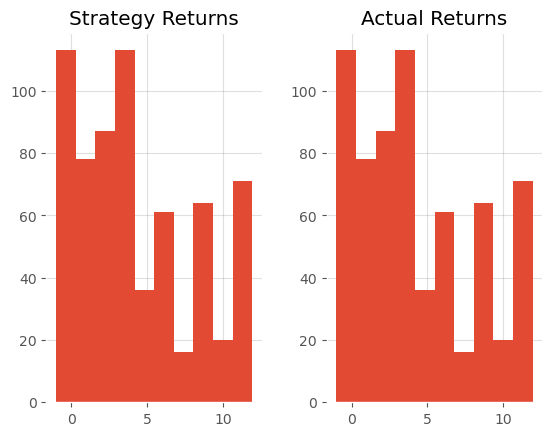

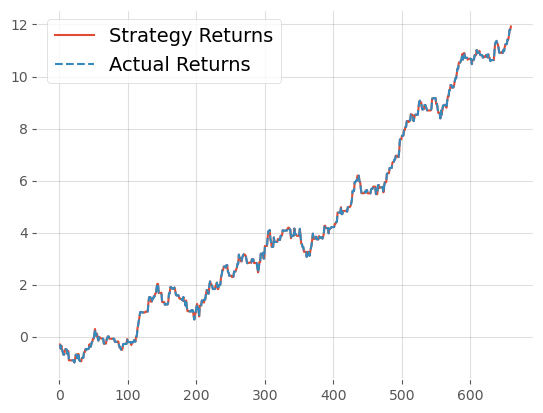

In [65]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata_insample = pd.DataFrame(index=X_train.index)

#backtestdata = pd.DataFrame()

backtestdata_insample["Adj Close"] = X_train["Adj Close"]
backtestdata_insample["pos_pred"] = predictions_insample
backtestdata_insample["pos_actual"] = Y_train
backtestdata_insample["Market Returns"] = X_train["Adj Close"].pct_change()
backtestdata_insample["Actual Returns"] = backtestdata_insample["Market Returns"] * backtestdata_insample["pos_actual"].shift(1)
backtestdata_insample["Strategy Returns"] = backtestdata_insample["Market Returns"] * backtestdata_insample["pos_pred"].shift(1)

backtestdata_insample = backtestdata_insample.reset_index()

backtestdata_insample.head()

backtestdata_insample[["Strategy Returns","Actual Returns"]].cumsum().hist()
backtestdata_insample[["Strategy Returns","Actual Returns"]].cumsum().plot(style=["-","--"])

In [66]:
backtestdata_insample.sort_values(by='Date', ascending=True).tail()

,Date,Adj Close,pos_pred,pos_actual,Market Returns,Actual Returns,Strategy Returns
555,2022-09-26,5.898005,1.0,1.0,0.325384,0.000000,0.000000
52,2022-09-27,5.895449,1.0,1.0,0.247986,0.247986,0.247986
25,2022-09-29,5.893824,1.0,1.0,0.122290,0.000000,0.000000
439,2022-09-30,5.878240,1.0,1.0,-0.023512,-0.023512,-0.023512
387,2022-10-25,5.953036,0.0,0.0,0.279341,0.279341,0.279341


In [67]:
# Sharpe Ratio
sharperatio(backtestdata_insample[['Strategy Returns']])

Strategy Returns    2.374316
dtype: float64

In [68]:
# Maximum Drawdown

backtestdata_insample["CUMULATIVE_RETURNS"] = backtestdata_insample["Strategy Returns"].dropna().cumsum()
backtestdata_insample["MAX_GROSS_PERFORMANCE"] = backtestdata_insample["CUMULATIVE_RETURNS"].cummax()

DRAWDOWN = backtestdata_insample["MAX_GROSS_PERFORMANCE"] - backtestdata_insample["CUMULATIVE_RETURNS"]
DRAWDOWN.max()

1.3732938117697222

In [69]:
backtestdata_insample.sort_values(by='Date', ascending=True).tail()

,Date,Adj Close,pos_pred,pos_actual,Market Returns,Actual Returns,Strategy Returns,CUMULATIVE_RETURNS,MAX_GROSS_PERFORMANCE
555,2022-09-26,5.898005,1.0,1.0,0.325384,0.000000,0.000000,8.599891,9.169528
52,2022-09-27,5.895449,1.0,1.0,0.247986,0.247986,0.247986,0.296347,0.296347
25,2022-09-29,5.893824,1.0,1.0,0.122290,0.000000,0.000000,-0.693908,-0.303409
439,2022-09-30,5.878240,1.0,1.0,-0.023512,-0.023512,-0.023512,5.939356,6.187736
387,2022-10-25,5.953036,0.0,0.0,0.279341,0.279341,0.279341,4.263541,4.263541


In [70]:
# CAGR (compound annual growth rate)

D = (max(backtestdata_insample["Date"]) - min(backtestdata_insample["Date"])).days

(backtestdata_insample["CUMULATIVE_RETURNS"].loc[backtestdata_insample["Date"] 
                                         == max(backtestdata_insample["Date"])]
 + 1 ) ** (365.0/D) - 1


387    0.096735
Name: CUMULATIVE_RETURNS, dtype: float64

In [71]:
# $500,000 How much is left on your account

500000 * (1 + backtestdata_insample["CUMULATIVE_RETURNS"].loc[backtestdata_insample["Date"]
                                                              == max(backtestdata_insample["Date"])])

387    2.631771e+06
Name: CUMULATIVE_RETURNS, dtype: float64

<AxesSubplot:>

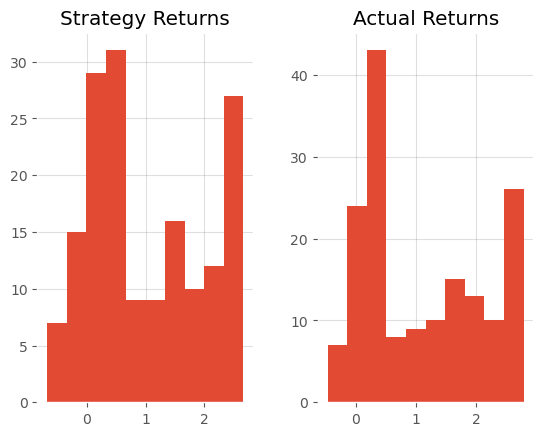

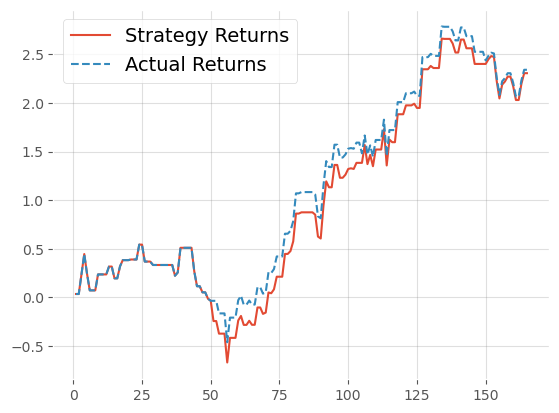

In [72]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)

#backtestdata = pd.DataFrame()

backtestdata["signal_pred"] = predictions
backtestdata["signal_actual"] = Y_validation
backtestdata["Market Returns"] = X_validation["Adj Close"].pct_change()
backtestdata["Actual Returns"] = backtestdata["Market Returns"] * backtestdata["signal_actual"].shift(1)
backtestdata["Strategy Returns"] = backtestdata["Market Returns"] * backtestdata["signal_pred"].shift(1)

backtestdata=backtestdata.reset_index()

backtestdata.head()

backtestdata[["Strategy Returns","Actual Returns"]].cumsum().hist()
backtestdata[["Strategy Returns","Actual Returns"]].cumsum().plot(style=["-","--"])

<AxesSubplot:>

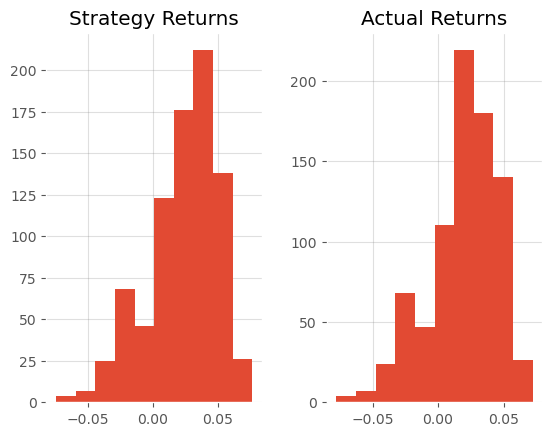

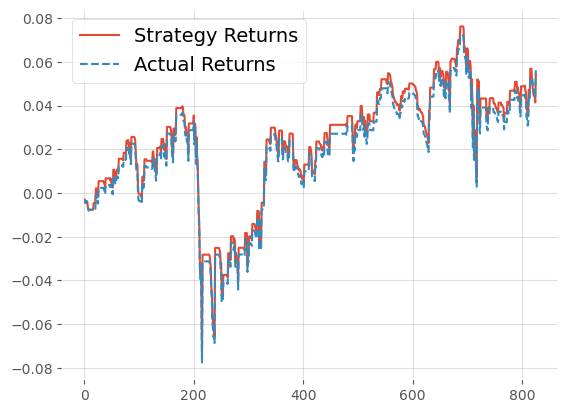

In [73]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata_fullsample = pd.DataFrame(index=X.index)

#backtestdata = pd.DataFrame()

backtestdata_fullsample["Adj Close"] = X["Adj Close"]
backtestdata_fullsample["pos_pred"] = predictions_fullsample
backtestdata_fullsample["pos_actual"] = Y
backtestdata_fullsample["Market Returns"] = X["Adj Close"].pct_change()
backtestdata_fullsample["Actual Returns"] = backtestdata_fullsample["Market Returns"] * backtestdata_fullsample["pos_actual"].shift(1)
backtestdata_fullsample["Strategy Returns"] = backtestdata_fullsample["Market Returns"] * backtestdata_fullsample["pos_pred"].shift(1)

backtestdata_fullsample = backtestdata_fullsample.reset_index()

backtestdata_fullsample.head()

backtestdata_fullsample[["Strategy Returns","Actual Returns"]].cumsum().hist()
backtestdata_fullsample[["Strategy Returns","Actual Returns"]].cumsum().plot(style=["-","--"])


<AxesSubplot:>

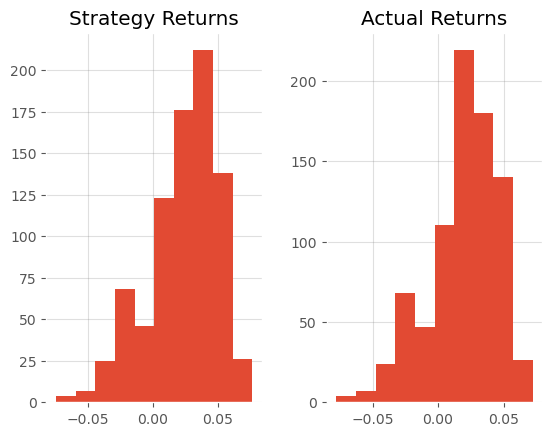

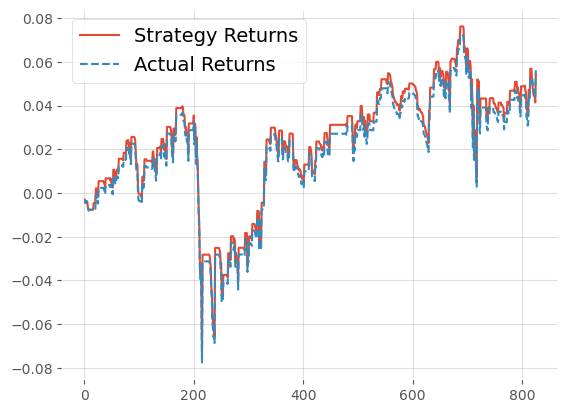

In [74]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata_fullsample = pd.DataFrame(index=X.index)

#backtestdata = pd.DataFrame()

backtestdata_fullsample["Adj Close"] = X["Adj Close"]
backtestdata_fullsample["pos_pred"] = predictions_fullsample
backtestdata_fullsample["pos_actual"] = Y
backtestdata_fullsample["Market Returns"] = X["Adj Close"].pct_change()
backtestdata_fullsample["Actual Returns"] = backtestdata_fullsample["Market Returns"] * backtestdata_fullsample["pos_actual"].shift(1)
backtestdata_fullsample["Strategy Returns"] = backtestdata_fullsample["Market Returns"] * backtestdata_fullsample["pos_pred"].shift(1)

backtestdata_fullsample = backtestdata_fullsample.reset_index()

backtestdata_fullsample.head()

backtestdata_fullsample[["Strategy Returns","Actual Returns"]].cumsum().hist()
backtestdata_fullsample[["Strategy Returns","Actual Returns"]].cumsum().plot(style=["-","--"])


In [75]:
# Sharpe Ratio
sharpe4 = sharperatio(backtestdata_fullsample[['Strategy Returns']])[0]
sharpe4

0.21602808132184628

In [76]:
# Maximum Drawdown

backtestdata_fullsample["CUMULATIVE_RETURNS"] = backtestdata_fullsample["Strategy Returns"].dropna().cumsum()
backtestdata_fullsample["MAX_GROSS_PERFORMANCE"] = backtestdata_fullsample["CUMULATIVE_RETURNS"].cummax()

DRAWDOWN = backtestdata_fullsample["MAX_GROSS_PERFORMANCE"] - backtestdata_fullsample["CUMULATIVE_RETURNS"]
MaxDrawdown4 = DRAWDOWN.max()
MaxDrawdown4

0.11421763978645527

In [77]:
backtestdata_fullsample.sort_values(by='Date', ascending=True).tail()

,Date,Adj Close,pos_pred,pos_actual,Market Returns,Actual Returns,Strategy Returns,CUMULATIVE_RETURNS,MAX_GROSS_PERFORMANCE
821,2022-09-26,5.898005,1.0,1.0,-0.001683,-0.001683,-0.001683,0.044812,0.076239
822,2022-09-27,5.895449,1.0,1.0,-0.000433,-0.000433,-0.000433,0.044379,0.076239
823,2022-09-29,5.893824,1.0,1.0,-0.000276,-0.000276,-0.000276,0.044103,0.076239
824,2022-09-30,5.878240,1.0,1.0,-0.002644,-0.002644,-0.002644,0.041459,0.076239
825,2022-10-25,5.953036,0.0,0.0,0.012724,0.012724,0.012724,0.054183,0.076239


In [78]:
# CAGR (compound annual growth rate)

D = (max(backtestdata_fullsample["Date"]) - min(backtestdata_fullsample["Date"])).days

CAGR4 = ((backtestdata_fullsample["CUMULATIVE_RETURNS"].loc[backtestdata_fullsample["Date"] 
                                         == max(backtestdata_fullsample["Date"])] + 1 ) ** (365.0/D) - 1).values[0]
CAGR4

0.0029379959420061663

In [79]:
# $500,000 How much is left on your account

RemainingCapital4 = (500000 * (1 + backtestdata_fullsample["CUMULATIVE_RETURNS"].loc[backtestdata_fullsample["Date"]
                                                              == max(backtestdata_fullsample["Date"])])).values[0]

RemainingCapital4

527091.5767191438

In [80]:
Performance_Tracker.loc[3] = ["ML+MeanReversion",sharpe4,CAGR4,MaxDrawdown4,RemainingCapital4]

### MACD + Random Forest

In [81]:
X0 = np.log(spy.loc[:, ("Adj Close","Low","High")])
# X0.index = X0.index.droplevel("Ticker")
X0.head()

X0["EWM_12"] = X0["Adj Close"].ewm(span=12, adjust=False, min_periods = 12).mean()
X0["EWM_26"] = X0["Adj Close"].ewm(span=26, adjust=False, min_periods = 26).mean()

X0["MACD"] = X0["EWM_12"] -  X0["EWM_26"]
X0["MACD_signal"] = X0["MACD"].ewm(span=9, adjust=False, min_periods = 9).mean()

X0["POS"] = np.where(X0["MACD"] > X0["MACD_signal"], 1, np.nan) 
X0["POS"] = np.where(X0["MACD"] < X0["MACD_signal"], -1, X0["POS"]) 

X0.dropna(axis = 0)

,Adj Close,Low,High,EWM_12,EWM_26,MACD,MACD_signal,POS
Date,,,,,,,,
2003-12-18,4.330249,4.685736,4.698023,4.312849,4.305310,0.007539,0.005931,1.0
2003-12-19,4.327461,4.687487,4.694737,4.315097,4.306951,0.008146,0.006374,1.0
2003-12-22,4.334416,4.689327,4.697385,4.318069,4.308985,0.009084,0.006916,1.0
2003-12-23,4.335054,4.694828,4.700026,4.320682,4.310916,0.009766,0.007486,1.0
2003-12-24,4.334051,4.695285,4.699389,4.322739,4.312630,0.010109,0.008010,1.0
...,...,...,...,...,...,...,...,...
2022-10-25,5.953036,5.936665,5.953892,5.917755,5.922076,-0.004321,-0.013170,1.0
2022-10-26,5.945473,5.943718,5.959922,5.922019,5.923809,-0.001790,-0.010894,1.0
2022-10-27,5.940119,5.938407,5.953243,5.924804,5.925017,-0.000213,-0.008758,1.0


In [82]:
# Moving Average

X0["MA21"] = MA(X0, 21)
X0["MA63"] = MA(X0, 63)
X0["MA252"] = MA(X0, 252)

#############################
# Exponential Moving Average

X0["EMA10"] = EMA(X0, 10)
X0["EMA30"] = EMA(X0, 30)
X0["EMA200"] = EMA(X0, 200)

#############################
# RSI 

X0["RSI10"] = RSI(X0["Adj Close"], 10)
X0["RSI30"] = RSI(X0["Adj Close"], 30)
X0["RSI200"] = RSI(X0["Adj Close"], 200)

#############################
# Stochastic Oscillator 

X0["%K10"] = STOK(X0["Adj Close"], X0["Low"], X0["High"], 10)
X0["%D10"] = STOD(X0["Adj Close"], X0["Low"], X0["High"], 10)

X0["%K30"] = STOK(X0["Adj Close"], X0["Low"], X0["High"], 30)
X0["%D30"] = STOD(X0["Adj Close"], X0["Low"], X0["High"], 30)

X0["%K200"] = STOK(X0["Adj Close"], X0["Low"], X0["High"], 200)
X0["%D200"] = STOD(X0["Adj Close"], X0["Low"], X0["High"], 200)

#############################
# Rate of Change (RoC)

X0["ROC10"] = ROC(X0["Adj Close"], 10)
X0["ROC30"] = ROC(X0["Adj Close"], 30)

X0.iloc[:, 4:] .head()

# Price Momentum

X0["MOM10"] = MOM(X0["Adj Close"], 10)
X0["MOM30"] = MOM(X0["Adj Close"], 30)

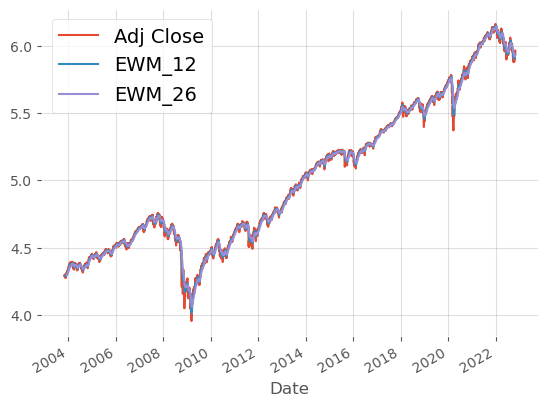

In [83]:
X0[["Adj Close","EWM_12","EWM_26"]
       ].plot()

plt.show()

In [84]:
X0 = X0.drop(["High", "Low", "EWM_12","EWM_26","MACD","MACD_signal"],
                       axis = 1
                      ) # note the axis 

In [85]:
X0 = X0.dropna(axis = 0) # note the axis

In [86]:
X0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4532 entries, 2004-11-01 to 2022-10-31
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  4532 non-null   float64
 1   POS        4532 non-null   float64
 2   MA21       4532 non-null   float64
 3   MA63       4532 non-null   float64
 4   MA252      4532 non-null   float64
 5   EMA10      4532 non-null   float64
 6   EMA30      4532 non-null   float64
 7   EMA200     4532 non-null   float64
 8   RSI10      4532 non-null   float64
 9   RSI30      4532 non-null   float64
 10  RSI200     4532 non-null   float64
 11  %K10       4532 non-null   float64
 12  %D10       4532 non-null   float64
 13  %K30       4532 non-null   float64
 14  %D30       4532 non-null   float64
 15  %K200      4532 non-null   float64
 16  %D200      4532 non-null   float64
 17  ROC10      4532 non-null   float64
 18  ROC30      4532 non-null   float64
 19  MOM10      4532 non-null   flo

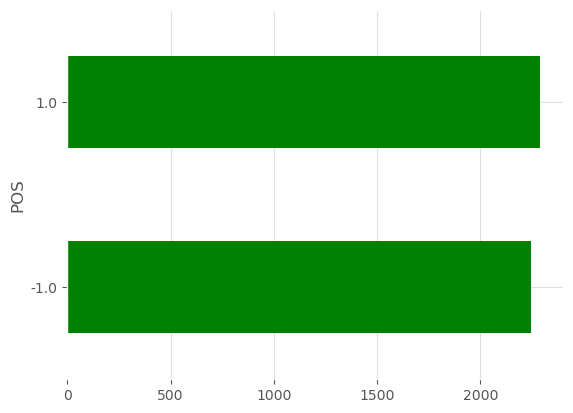

In [87]:
fig = plt.figure()

plot = X0.groupby(["POS"]).size().plot(kind = "barh", color = "green")

plt.show()

In [88]:
subset_dataset = X0.iloc[:]

Y = subset_dataset["POS"]

X = subset_dataset.loc[:, X0.columns != "POS"]

validation_size = 0.2

seed = 1

X_train, X_validation, Y_train, Y_validation = train_test_split(X, 
                                                                Y, 
                                                                test_size = validation_size, 
                                                                random_state = 1)

In [89]:
# test options for classification
num_folds = 10
seed = 7
scoring = "accuracy"
# scoring = "precision"
# scoring = "recall"
# scoring ="neg_log_loss"
# scoring = "roc_auc"

In [90]:
# spot check the algorithms

models = []

models.append(("LR", LogisticRegression(n_jobs = -1)
              )
             )

models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))

#Neural Network
models.append(("NN", MLPClassifier()))

# Ensable Models 

# Boosting methods
models.append(("AB", AdaBoostClassifier()))
models.append(("GBM", GradientBoostingClassifier()))

# Bagging methods
models.append(("RF", RandomForestClassifier(n_jobs = -1)
              )
             )

In [91]:
results = []

names = []

for name, model in models:
    kfold = KFold(n_splits = num_folds, 
                  random_state = seed, 
                  shuffle = True)
    cv_results = cross_val_score(model, 
                                 X_train, 
                                 Y_train, 
                                 cv = kfold, 
                                 scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.872826 (0.011544)
LDA: 0.907580 (0.012450)
KNN: 0.773788 (0.015674)
CART: 0.844688 (0.022015)
NB: 0.742627 (0.014955)
NN: 0.851875 (0.023791)
AB: 0.867038 (0.005404)
GBM: 0.881384 (0.010565)
RF: 0.899034 (0.011925)


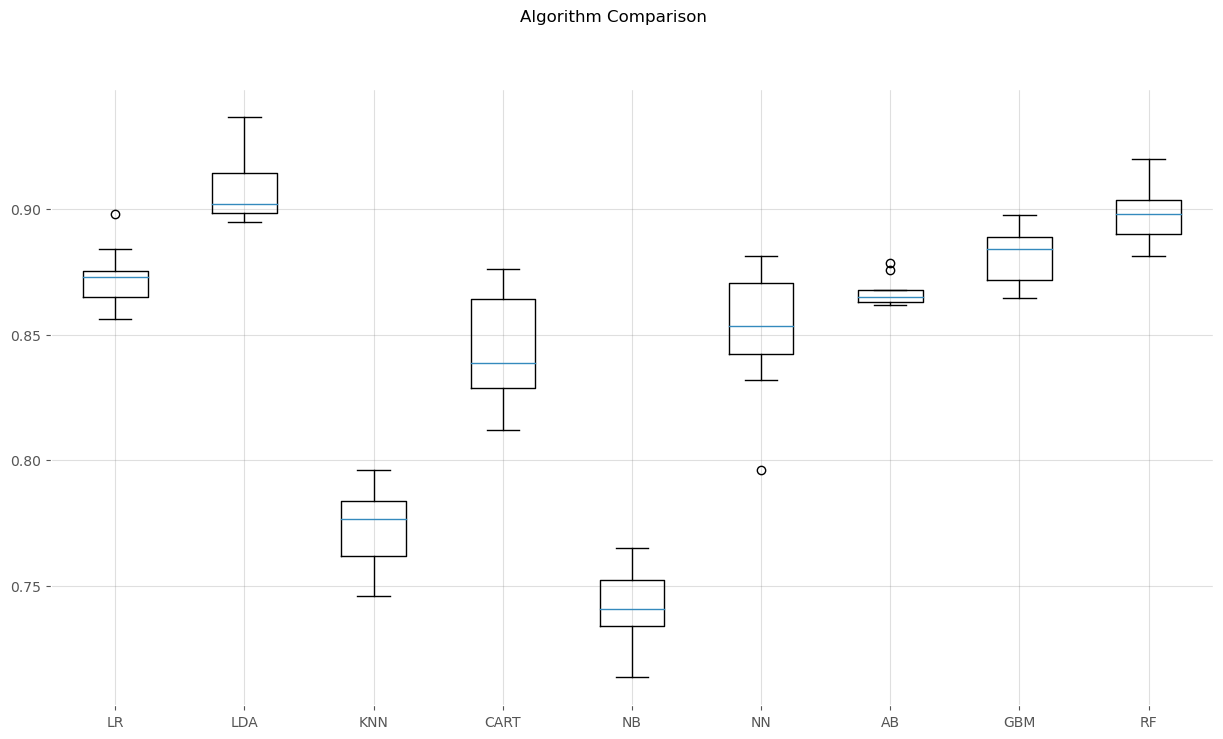

In [92]:
fig = plt.figure()
fig.suptitle("Algorithm Comparison")

ax = fig.add_subplot(111)

plt.boxplot(results)

ax.set_xticklabels(names)

fig.set_size_inches(15,8)

plt.show()

In [93]:
# Grid Search: Random Forest Classifier
"""
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
"""
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

n_estimators = [20,80]
max_depth= [5,10]

criterion = ["gini","entropy"]

param_grid = dict(n_estimators = n_estimators, 
                  max_depth = max_depth, 
                  criterion = criterion )

model = RandomForestClassifier(n_jobs = -1)

kfold = KFold(n_splits = num_folds, 
              random_state = seed, shuffle = True)

grid = GridSearchCV(estimator = model, 
                    param_grid = param_grid, 
                    scoring = scoring, 
                    cv = kfold)

grid_result = grid.fit(rescaledX, Y_train)

# Print .
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
ranks = grid_result.cv_results_["rank_test_score"]

for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.892137 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#7 0.859309 (0.009181) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.859584 (0.009465) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.884962 (0.013444) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#2 0.889101 (0.009891) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.857382 (0.011807) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#5 0.861794 (0.011986) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.882760 (0.012899) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.892137 (0.010298) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [94]:
# prepare model
model = RandomForestClassifier(criterion = "gini", 
                               n_estimators = 80,
                               max_depth = 10,
                               n_jobs = -1) # rbf is default kernel

#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [95]:
# estimate accuracy on train set
predictions_insample = model.predict(X_train)

print(accuracy_score(Y_train, predictions_insample)
     )
print(confusion_matrix(Y_train, predictions_insample)
     )
print(classification_report(Y_train, predictions_insample)
     )

0.9817931034482759
[[1754   30]
 [  36 1805]]
              precision    recall  f1-score   support

        -1.0       0.98      0.98      0.98      1784
         1.0       0.98      0.98      0.98      1841

    accuracy                           0.98      3625
   macro avg       0.98      0.98      0.98      3625
weighted avg       0.98      0.98      0.98      3625



In [96]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)

print(accuracy_score(Y_validation, predictions)
     )
print(confusion_matrix(Y_validation, predictions)
     )
print(classification_report(Y_validation, predictions)
     )

0.8941565600882029
[[416  45]
 [ 51 395]]
              precision    recall  f1-score   support

        -1.0       0.89      0.90      0.90       461
         1.0       0.90      0.89      0.89       446

    accuracy                           0.89       907
   macro avg       0.89      0.89      0.89       907
weighted avg       0.89      0.89      0.89       907



In [97]:
# estimate accuracy on the full set
predictions_fullsample = model.predict(X)

print(accuracy_score(Y, predictions_fullsample)
     )
print(confusion_matrix(Y, predictions_fullsample)
     )
print(classification_report(Y, predictions_fullsample)
     )

0.9642541924095323
[[2170   75]
 [  87 2200]]
              precision    recall  f1-score   support

        -1.0       0.96      0.97      0.96      2245
         1.0       0.97      0.96      0.96      2287

    accuracy                           0.96      4532
   macro avg       0.96      0.96      0.96      4532
weighted avg       0.96      0.96      0.96      4532



In [98]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata_insample = pd.DataFrame(index=X_train.index)

#backtestdata = pd.DataFrame()

backtestdata_insample["Adj Close"] = X_train["Adj Close"]
backtestdata_insample["pos_pred"] = predictions_insample
backtestdata_insample["pos_actual"] = Y_train
backtestdata_insample["Market Returns"] = X_train["Adj Close"].pct_change()
backtestdata_insample["Actual Returns"] = backtestdata_insample["Market Returns"] * backtestdata_insample["pos_actual"].shift(1)
backtestdata_insample["Strategy Returns"] = backtestdata_insample["Market Returns"] * backtestdata_insample["pos_pred"].shift(1)

backtestdata_insample = backtestdata_insample.reset_index()

backtestdata_insample.head()

,Date,Adj Close,pos_pred,pos_actual,Market Returns,Actual Returns,Strategy Returns
0,2006-08-01,4.527780,1.0,1.0,NaN,NaN,NaN
1,2016-11-30,5.289390,1.0,1.0,0.168208,0.168208,0.168208
2,2016-06-16,5.223127,-1.0,-1.0,-0.012528,-0.012528,-0.012528
3,2008-07-28,4.537394,1.0,1.0,-0.131288,0.131288,0.131288
4,2016-10-25,5.260807,1.0,1.0,0.159434,0.159434,0.159434


<AxesSubplot:>

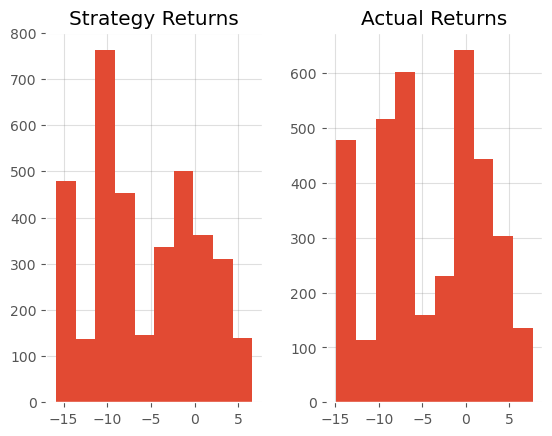

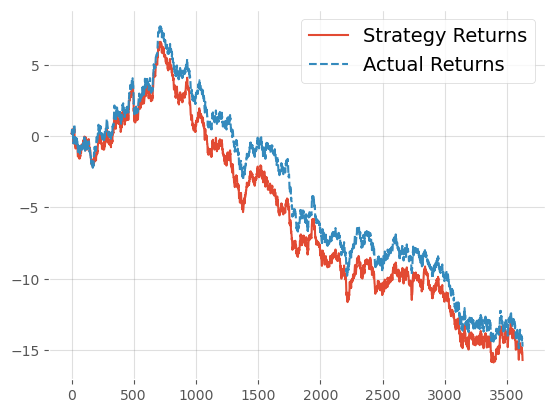

In [99]:
backtestdata_insample[["Strategy Returns","Actual Returns"]].cumsum().hist()
backtestdata_insample[["Strategy Returns","Actual Returns"]].cumsum().plot(style=["-","--"])

In [100]:
backtestdata_insample.sort_values(by='Date', ascending=True).tail()

,Date,Adj Close,pos_pred,pos_actual,Market Returns,Actual Returns,Strategy Returns
1769,2022-10-17,5.904871,1.0,1.0,0.133654,-0.133654,-0.133654
498,2022-10-18,5.916552,1.0,1.0,0.251325,-0.251325,-0.251325
3285,2022-10-24,5.937193,1.0,1.0,0.252030,0.252030,0.252030
2063,2022-10-25,5.953036,1.0,1.0,-0.013580,0.013580,0.013580
991,2022-10-31,5.956381,1.0,1.0,0.132148,0.132148,0.132148


In [101]:
# Sharpe Ratio
sharperatio(backtestdata_insample[['Strategy Returns']])

Strategy Returns   -0.450546
dtype: float64

In [102]:
# Maximum Drawdown

backtestdata_insample["CUMULATIVE_RETURNS"] = backtestdata_insample["Strategy Returns"].dropna().cumsum()
backtestdata_insample["MAX_GROSS_PERFORMANCE"] = backtestdata_insample["CUMULATIVE_RETURNS"].cummax()

DRAWDOWN = backtestdata_insample["MAX_GROSS_PERFORMANCE"] - backtestdata_insample["CUMULATIVE_RETURNS"]
DRAWDOWN.max()

22.459549585500604

In [103]:
# CAGR (compound annual growth rate)

D = (max(backtestdata_insample["Date"]) - min(backtestdata_insample["Date"])).days

(backtestdata_insample["CUMULATIVE_RETURNS"].loc[backtestdata_insample["Date"] 
                                         == max(backtestdata_insample["Date"])] + 1 ) ** (365.0/D) - 1



991    0.023046
Name: CUMULATIVE_RETURNS, dtype: float64

In [104]:
# $500,000 How much is left on your account

500000 * (1 + backtestdata_insample["CUMULATIVE_RETURNS"].loc[backtestdata_insample["Date"]
                                                              == max(backtestdata_insample["Date"])])

991    753634.352984
Name: CUMULATIVE_RETURNS, dtype: float64

<AxesSubplot:>

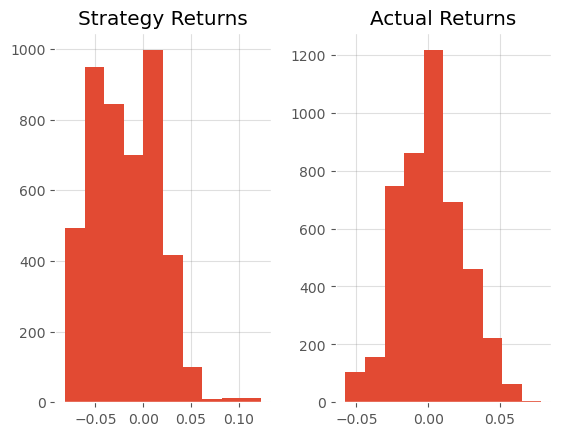

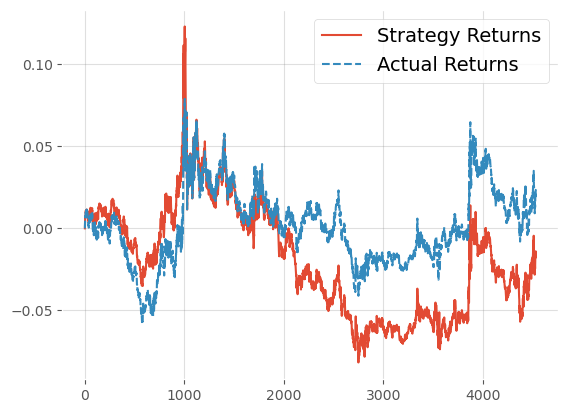

In [105]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata_fullsample = pd.DataFrame(index=X.index)

#backtestdata = pd.DataFrame()

backtestdata_fullsample["Adj Close"] = X["Adj Close"]
backtestdata_fullsample["pos_pred"] = predictions_fullsample
backtestdata_fullsample["pos_actual"] = Y
backtestdata_fullsample["Market Returns"] = X["Adj Close"].pct_change()
backtestdata_fullsample["Actual Returns"] = backtestdata_fullsample["Market Returns"] * backtestdata_fullsample["pos_actual"].shift(1)
backtestdata_fullsample["Strategy Returns"] = backtestdata_fullsample["Market Returns"] * backtestdata_fullsample["pos_pred"].shift(1)

backtestdata_fullsample = backtestdata_fullsample.reset_index()

backtestdata_fullsample.head()

backtestdata_fullsample[["Strategy Returns","Actual Returns"]].cumsum().hist()
backtestdata_fullsample[["Strategy Returns","Actual Returns"]].cumsum().plot(style=["-","--"])



In [106]:
# Sharpe Ratio
sharpe5 = sharperatio(backtestdata_fullsample['Strategy Returns'])
sharpe5

-0.020629469749873043

In [107]:
# Maximum Drawdown

backtestdata_fullsample["CUMULATIVE_RETURNS"] = backtestdata_fullsample["Strategy Returns"].dropna().cumsum()
backtestdata_fullsample["MAX_GROSS_PERFORMANCE"] = backtestdata_fullsample["CUMULATIVE_RETURNS"].cummax()

DRAWDOWN = backtestdata_fullsample["MAX_GROSS_PERFORMANCE"] - backtestdata_fullsample["CUMULATIVE_RETURNS"]
MaxDrawdown5 = DRAWDOWN.max()
MaxDrawdown5

0.20489431385118417

In [108]:
# CAGR (compound annual growth rate)

D = (max(backtestdata_fullsample["Date"]) - min(backtestdata_fullsample["Date"])).days

CAGR5 = ((backtestdata_fullsample["CUMULATIVE_RETURNS"].loc[backtestdata_fullsample["Date"] 
                                         == max(backtestdata_fullsample["Date"])] + 1) ** (365.0/D) - 1).values[0]

CAGR5

-0.0008463688979284401

In [109]:
# $500,000 How much is left on your account

RemainingCapital5 = (500000 * (1 + backtestdata_fullsample["CUMULATIVE_RETURNS"].loc[backtestdata_fullsample["Date"]
                                                              == max(backtestdata_fullsample["Date"])])).values[0]

RemainingCapital5

492433.80631329643

In [110]:
Performance_Tracker.loc[4] = ["MACD+RF",sharpe5,CAGR5,MaxDrawdown5,RemainingCapital5]

### Logistic Regression (BS)
<a id="lag14"></a>

In [111]:
SPY_LOG = spy.copy()

In [112]:
SPY_LOG["RETURNS"] = SPY_LOG["Adj Close"].pct_change().dropna()

In [113]:
SPY_Test = SPY_LOG[["Adj Close","RETURNS"]].copy()

In [114]:
lags = 30

# create a list `cols` to contain all lag terms column names
cols = []

# use for loop to get all lag values
for lag in range(1, lags +1):
    col = "lag_{}".format(lag)
    SPY_LOG[col] = SPY_LOG["RETURNS"].shift(lag)
    cols.append(col)            # store all lag column names, will be used in future 
    
SPY_LOG.dropna(inplace = True)  

In [115]:
M = linear_model.LogisticRegression(solver = "lbfgs",
                                    C = 1e7,
                                    multi_class = "auto",
                                    max_iter = 1000)

In [116]:
def confusion_matrix(act,pred):
    predtrans = ["Up" if i == 1 else "Down" for i in pred]
    actuals = ["Up" if i > 0 else "Down" for i in act]
    confusion_matrix = pd.crosstab(pd.Series(actuals),
                                  pd.Series(predtrans),
                                  rownames=["Actual"],
                                  colnames=["Predicted"])
    return confusion_matrix

In [117]:
def Lag_Test(lag):

    M.fit(SPY_LOG[cols[:lag]],
         np.sign(SPY_LOG["RETURNS"]      # The sign function returns -1 if x < 0, 0 if x==0, 1 if x > 0.
                )
         )

    SPY_LOG['PREDICTION_'+str(lag)] = M.predict(SPY_LOG[cols[:lag]])

    confusion = confusion_matrix(SPY_LOG["RETURNS"],SPY_LOG['PREDICTION_'+str(lag)])
    
    accuracy = (confusion.iloc[1]["Up"] + confusion.iloc[0]["Down"])/len(SPY_LOG["RETURNS"])
    
    return accuracy,confusion


In [118]:
accuracy = []

for i in np.arange(1,lags +1,1):
    accuracy.append(Lag_Test(i)[0])
    
np.argmax(accuracy)

14

In [119]:
Lag_Test(14)

(0.5542929292929293,
 Predicted  Down    Up
 Actual               
 Down         65  2071
 Up           47  2569)

<AxesSubplot:xlabel='Date'>

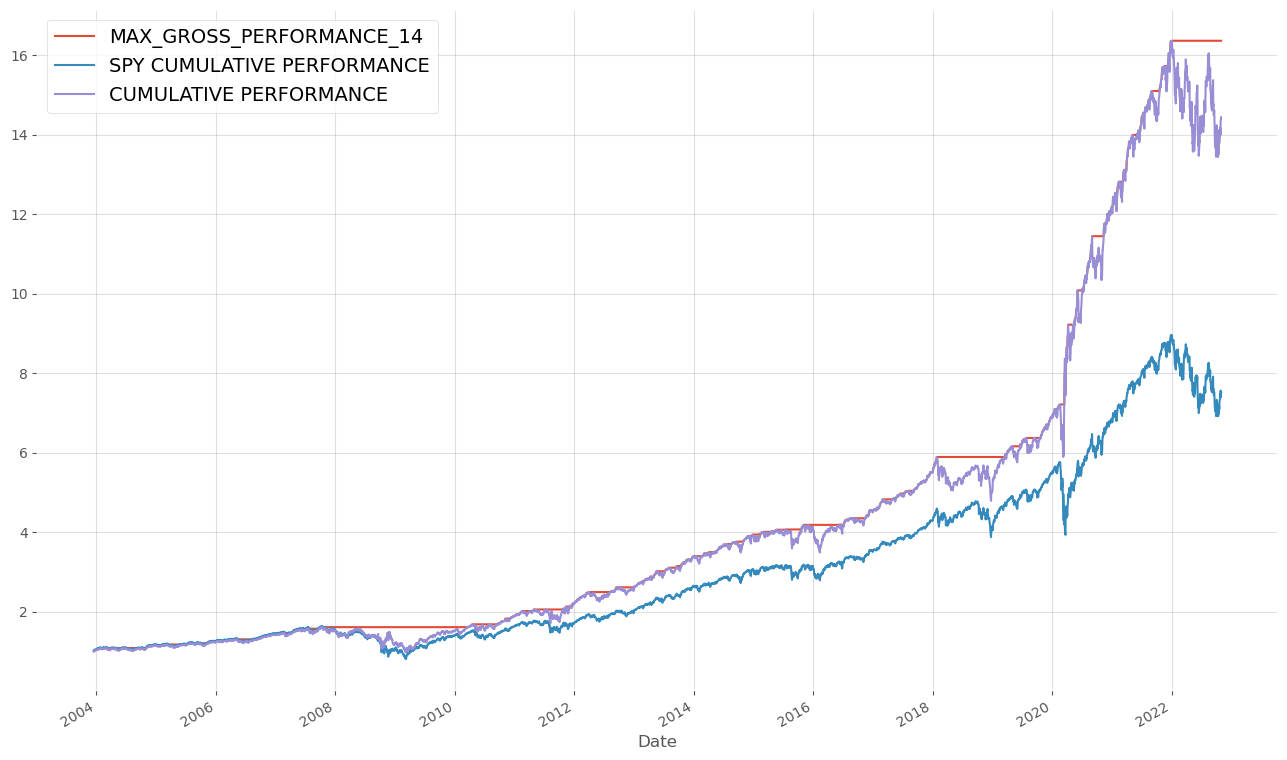

In [120]:
SPY_Test['STRATEGY_14'] = SPY_LOG['PREDICTION_14'] * SPY_LOG['RETURNS'] 
SPY_Test["CUMULATIVE PERFORMANCE"] = SPY_Test["STRATEGY_14"].cumsum().apply(np.exp)
SPY_Test["SPY CUMULATIVE PERFORMANCE"] = SPY_Test["RETURNS"].cumsum().apply(np.exp)
SPY_Test["MAX_GROSS_PERFORMANCE_14"] = SPY_Test["CUMULATIVE PERFORMANCE"].cummax()

SPY_Test = SPY_Test.dropna()

SPY_Test[["MAX_GROSS_PERFORMANCE_14", 
    "SPY CUMULATIVE PERFORMANCE",
      "CUMULATIVE PERFORMANCE"]].plot(figsize = (16, 10)
                                                 )

In [121]:
sharpe6 = sharperatio(SPY_Test["STRATEGY_14"])

In [122]:
D = (SPY_Test.index[-1] - SPY_Test.index[0]).days
CAGR6 = (((SPY_Test[['STRATEGY_14']].cumsum().apply(np.exp).tail(1).values[0][0]) / (1)) ** (365.0/D)) - 1
CAGR6

0.15181607404331166

In [123]:
DRAWDOWN2 = SPY_Test["MAX_GROSS_PERFORMANCE_14"] - SPY_Test["CUMULATIVE PERFORMANCE"]
MaxDrawdown6 = DRAWDOWN2.max()

In [124]:
PERIOD2 = (DRAWDOWN2[DRAWDOWN2 == 0].index[1:].to_pydatetime() - 
          DRAWDOWN2[DRAWDOWN2 == 0].index[:-1].to_pydatetime()
          )
PERIOD2.max()

datetime.timedelta(days=896)

In [125]:
RemainingCapital6 = (500000 * (1 + SPY_Test["CUMULATIVE PERFORMANCE"].loc[SPY_Test.index
                                                == max(SPY_Test.index)])).values[0]
RemainingCapital6


7716962.973818011

In [126]:
Performance_Tracker.loc[5] = ["LogisticRegression_lag14",sharpe6,CAGR6,MaxDrawdown6,RemainingCapital6]

### Logistic Regression 2 (TV)
<a id="logreg2"></a>

In [127]:
data = np.log(spy[["Adj Close","Low","High"]][1:])
data

,Adj Close,Low,High
Date,,,
2003-11-03,4.295662,4.660699,4.669177
2003-11-04,4.293490,4.659469,4.665983
2003-11-05,4.294246,4.653008,4.663156
2003-11-06,4.299523,4.654912,4.667581
2003-11-07,4.292070,4.659374,4.670209
...,...,...,...
2022-10-25,5.953036,5.936665,5.953892
2022-10-26,5.945473,5.943718,5.959922
2022-10-27,5.940119,5.938407,5.953243


In [128]:
data["EWM_12"] = data["Adj Close"].ewm(span=12, adjust=False, min_periods = 12).mean()
data["EWM_26"] = data["Adj Close"].ewm(span=26, adjust=False, min_periods = 26).mean()

data["MACD"] = data["EWM_12"] -  data["EWM_26"]
data["MACD_signal"] = data["MACD"].ewm(span=9, adjust=False, min_periods = 9).mean()

data["POS"] = np.where(data["MACD"] > data["MACD_signal"], 1, np.nan) 
data["POS"] = np.where(data["MACD"] < data["MACD_signal"], -1, data["POS"]) 

data.dropna(axis = 0)

,Adj Close,Low,High,EWM_12,EWM_26,MACD,MACD_signal,POS
Date,,,,,,,,
2003-12-19,4.327461,4.687487,4.694737,4.315120,4.307428,0.007692,0.005743,1.0
2003-12-22,4.334416,4.689327,4.697385,4.318088,4.309427,0.008661,0.006327,1.0
2003-12-23,4.335054,4.694828,4.700026,4.320698,4.311325,0.009373,0.006936,1.0
2003-12-24,4.334051,4.695285,4.699389,4.322753,4.313009,0.009744,0.007498,1.0
2003-12-26,4.334781,4.697111,4.701207,4.324603,4.314622,0.009982,0.007994,1.0
...,...,...,...,...,...,...,...,...
2022-10-25,5.953036,5.936665,5.953892,5.917755,5.922076,-0.004321,-0.013170,1.0
2022-10-26,5.945473,5.943718,5.959922,5.922019,5.923809,-0.001790,-0.010894,1.0
2022-10-27,5.940119,5.938407,5.953243,5.924804,5.925017,-0.000213,-0.008758,1.0


In [129]:
data["MA12"] = MA(data, 12)
data["MA28"] = MA(data, 28)
data["MA200"] = MA(data, 200)

data["EMA10"] = EMA(data, 10)
data["EMA30"] = EMA(data, 30)
data["EMA200"] = EMA(data, 200)

data["RSI14"] = RSI(data["Adj Close"], 14)
data["RSI30"] = RSI(data["Adj Close"], 30)
data["RSI100"] = RSI(data["Adj Close"], 100)

data["%K14"] = STOK(data["Adj Close"], data["Low"], data["High"], 14)
data["%D14"] = STOD(data["Adj Close"], data["Low"], data["High"], 14)

data["%K30"] = STOK(data["Adj Close"], data["Low"], data["High"], 30)
data["%D30"] = STOD(data["Adj Close"], data["Low"], data["High"], 30)

data["%K200"] = STOK(data["Adj Close"], data["Low"], data["High"], 200)
data["%D200"] = STOD(data["Adj Close"], data["Low"], data["High"], 200)

data["ROC10"] = ROC(data["Adj Close"], 10)
data["ROC30"] = ROC(data["Adj Close"], 30)

data["MOM10"] = MOM(data["Adj Close"], 10)
data["MOM30"] = MOM(data["Adj Close"], 30)

In [130]:
data = data.drop(["High", "Low"],
                 axis = 1
                )

data = data.dropna(axis = 0)

In [131]:
subset_dataset = data.iloc[:]

Y = subset_dataset["POS"]

X = subset_dataset.loc[:, data.columns != "POS"]

validation_size = 0.2

seed = 1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size = validation_size, 
                                                    random_state = 1)

num_folds = 10
seed = 7
scoring = "accuracy"

In [132]:
# Grid Search: Random Forest Classifier
"""
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    
criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
"""
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

n_estimators = [20,80]
max_depth= [5,10]

criterion = ["gini","entropy"]

param_grid = dict(n_estimators = n_estimators, 
                  max_depth = max_depth, 
                  criterion = criterion )

model = RandomForestClassifier(n_jobs = -1)

kfold = KFold(n_splits = num_folds)

grid = GridSearchCV(estimator = model, 
                    param_grid = param_grid, 
                    scoring = scoring, 
                    cv = kfold)

grid_result = grid.fit(rescaledX, Y_train)

# Print .
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
ranks = grid_result.cv_results_["rank_test_score"]

for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.906938 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#6 0.869817 (0.010683) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.873922 (0.013773) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#4 0.900393 (0.020353) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.906938 (0.015049) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.867634 (0.011304) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#8 0.867366 (0.013807) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#3 0.902577 (0.016360) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#2 0.906668 (0.014696) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [133]:
model = LogisticRegression() 
model.fit(X_train, Y_train)

LogisticRegression()

In [134]:
# estimate accuracy on train set
predictions_insample = model.predict(X_train)

print(accuracy_score(Y_train, predictions_insample)
     )
print(confusion_matrix(Y_train, predictions_insample)
     )
print(classification_report(Y_train, predictions_insample)
     )

0.8687227074235808
Predicted  Down    Up
Actual               
Down       1566   252
Up          229  1617
              precision    recall  f1-score   support

        -1.0       0.87      0.86      0.87      1818
         1.0       0.87      0.88      0.87      1846

    accuracy                           0.87      3664
   macro avg       0.87      0.87      0.87      3664
weighted avg       0.87      0.87      0.87      3664



In [135]:
# estimate accuracy on validation set
predictions = model.predict(X_test)

print(accuracy_score(Y_test, predictions)
     )
print(confusion_matrix(Y_test, predictions)
     )
print(classification_report(Y_test, predictions)
     )

0.8451472191930207
Predicted  Down   Up
Actual              
Down        384   63
Up           79  391
              precision    recall  f1-score   support

        -1.0       0.83      0.86      0.84       447
         1.0       0.86      0.83      0.85       470

    accuracy                           0.85       917
   macro avg       0.85      0.85      0.85       917
weighted avg       0.85      0.85      0.85       917



In [136]:
model = LogisticRegression() 
model.fit(X_train, Y_train)

LogisticRegression()

In [137]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata_insample = pd.DataFrame(index=X_train.index)

#backtestdata = pd.DataFrame()

backtestdata_insample["Adj Close"] = X_train["Adj Close"]
backtestdata_insample["pos_pred"] = predictions_insample
backtestdata_insample["pos_actual"] = Y_train
backtestdata_insample["Market Returns"] = X_train["Adj Close"].pct_change()
backtestdata_insample["Actual Returns"] = backtestdata_insample["Market Returns"] * backtestdata_insample["pos_actual"].shift(1)
backtestdata_insample["Strategy Returns"] = backtestdata_insample["Market Returns"] * backtestdata_insample["pos_pred"].shift(1)

backtestdata_insample = backtestdata_insample.reset_index()

backtestdata_insample.head()

,Date,Adj Close,pos_pred,pos_actual,Market Returns,Actual Returns,Strategy Returns
0,2018-04-03,5.486804,-1.0,-1.0,NaN,NaN,NaN
1,2016-09-12,5.265850,-1.0,-1.0,-0.040270,0.040270,0.040270
2,2015-02-11,5.190622,1.0,1.0,-0.014286,0.014286,0.014286
3,2015-10-12,5.178622,1.0,1.0,-0.002312,-0.002312,-0.002312
4,2007-10-24,4.725252,-1.0,-1.0,-0.087546,-0.087546,-0.087546


<AxesSubplot:>

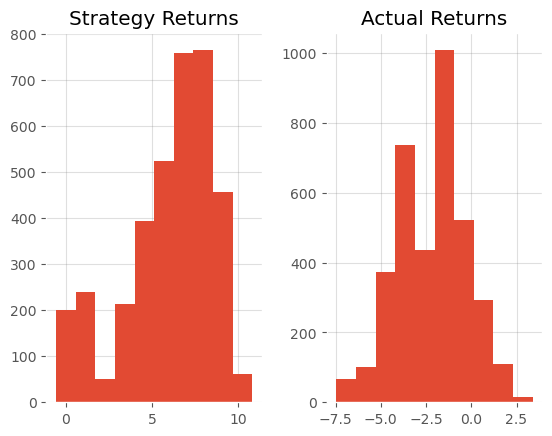

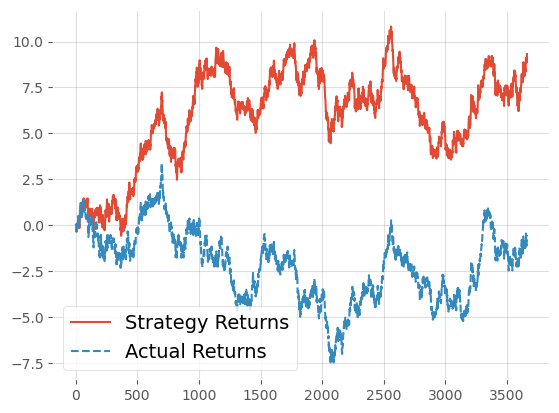

In [138]:
backtestdata_insample[["Strategy Returns","Actual Returns"]].cumsum().hist()
backtestdata_insample[["Strategy Returns","Actual Returns"]].cumsum().plot(style=["-","--"])

In [139]:
backtestdata_insample.sort_values(by='Date', ascending=True).tail()

,Date,Adj Close,pos_pred,pos_actual,Market Returns,Actual Returns,Strategy Returns
564,2022-10-18,5.916552,1.0,1.0,0.259819,0.259819,0.259819
986,2022-10-19,5.909441,1.0,1.0,0.384312,-0.384312,-0.384312
3323,2022-10-24,5.937193,1.0,1.0,0.259847,-0.259847,0.259847
2117,2022-10-25,5.953036,1.0,1.0,-0.013580,0.013580,0.013580
1095,2022-10-31,5.956381,1.0,1.0,0.059348,-0.059348,-0.059348


In [140]:
cap = 500000

In [141]:
sharpe7 = sharperatio(backtestdata_insample['Strategy Returns'])
sharpe7

0.26523885128205005

In [142]:
backtestdata_insample['CURET'] = backtestdata_insample['Strategy Returns'].cumsum()
final_port_value_7 = cap * backtestdata_insample['CURET'].iloc[-1]
D = (backtestdata_insample.index[-1] - backtestdata_insample.index[0])

CAGR7 = (final_port_value_7 / cap) ** (365/D) - 1
CAGR7

0.24905041457681687

In [143]:
backtestdata_insample["CUMULATIVE_RETURNS"] = backtestdata_insample["Strategy Returns"].dropna().cumsum()
backtestdata_insample["MAX_GROSS_PERFORMANCE"] = backtestdata_insample["CUMULATIVE_RETURNS"].cummax()

DRAWDOWN = backtestdata_insample["MAX_GROSS_PERFORMANCE"] - backtestdata_insample["CUMULATIVE_RETURNS"]
MaxDrawdown7 = DRAWDOWN.max()
MaxDrawdown7

7.239366660564655

In [144]:
RemainingCapital7 = final_port_value_7
RemainingCapital7

4658107.612080598

In [145]:
Performance_Tracker.loc[6] = ["ML+LogisticRegression",sharpe7,CAGR7,MaxDrawdown7,RemainingCapital7]

### Machine Learning - Random Forest (TV)
<a id="RandomForest"></a>

In [146]:
# prepare model
model = RandomForestClassifier(criterion = "gini", 
                               n_estimators = 80,
                               max_depth = 10,
                               n_jobs = -1) # rbf is default kernel

model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [147]:
# estimate accuracy on train set
predictions_insample = model.predict(X_train)

print(accuracy_score(Y_train, predictions_insample)
     )
print(confusion_matrix(Y_train, predictions_insample)
     )
print(classification_report(Y_train, predictions_insample)
     )

0.986353711790393
Predicted  Down    Up
Actual               
Down       1793    25
Up           25  1821
              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99      1818
         1.0       0.99      0.99      0.99      1846

    accuracy                           0.99      3664
   macro avg       0.99      0.99      0.99      3664
weighted avg       0.99      0.99      0.99      3664



In [148]:
# estimate accuracy on validation set
predictions = model.predict(X_test)

print(accuracy_score(Y_test, predictions)
     )
print(confusion_matrix(Y_test, predictions)
     )
print(classification_report(Y_test, predictions)
     )

0.8865866957470011
Predicted  Down   Up
Actual              
Down        402   45
Up           59  411
              precision    recall  f1-score   support

        -1.0       0.87      0.90      0.89       447
         1.0       0.90      0.87      0.89       470

    accuracy                           0.89       917
   macro avg       0.89      0.89      0.89       917
weighted avg       0.89      0.89      0.89       917



In [149]:
# prepare model
model = RandomForestClassifier(criterion = "gini", 
                               n_estimators = 80,
                               max_depth = 10,
                               n_jobs = -1) # rbf is default kernel

#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

Text(0.5, 0, 'Variable Importance')

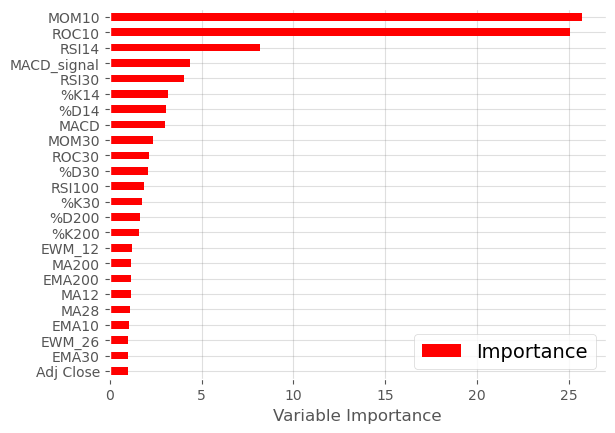

In [150]:
Importance = pd.DataFrame({"Importance":model.feature_importances_*100}, 
                          index=X.columns)
Importance.sort_values("Importance", 
                       axis = 0, 
                       ascending = True).plot(kind="barh", color="r" )

plt.xlabel("Variable Importance")

In [151]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata_insample = pd.DataFrame(index=X_train.index)

#backtestdata = pd.DataFrame()

backtestdata_insample["Adj Close"] = X_train["Adj Close"]
backtestdata_insample["pos_pred"] = predictions_insample
backtestdata_insample["pos_actual"] = Y_train
backtestdata_insample["Market Returns"] = X_train["Adj Close"].pct_change()
backtestdata_insample["Actual Returns"] = backtestdata_insample["Market Returns"] * backtestdata_insample["pos_actual"].shift(1)
backtestdata_insample["Strategy Returns"] = backtestdata_insample["Market Returns"] * backtestdata_insample["pos_pred"].shift(1)

backtestdata_insample = backtestdata_insample.reset_index()

backtestdata_insample.head()

,Date,Adj Close,pos_pred,pos_actual,Market Returns,Actual Returns,Strategy Returns
0,2018-04-03,5.486804,-1.0,-1.0,NaN,NaN,NaN
1,2016-09-12,5.265850,-1.0,-1.0,-0.040270,0.040270,0.040270
2,2015-02-11,5.190622,1.0,1.0,-0.014286,0.014286,0.014286
3,2015-10-12,5.178622,1.0,1.0,-0.002312,-0.002312,-0.002312
4,2007-10-24,4.725252,-1.0,-1.0,-0.087546,-0.087546,-0.087546


<AxesSubplot:>

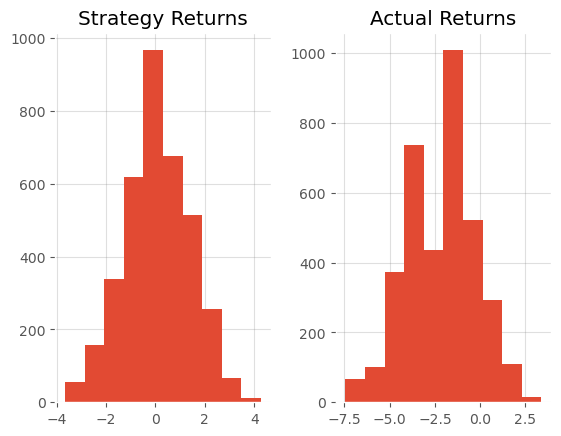

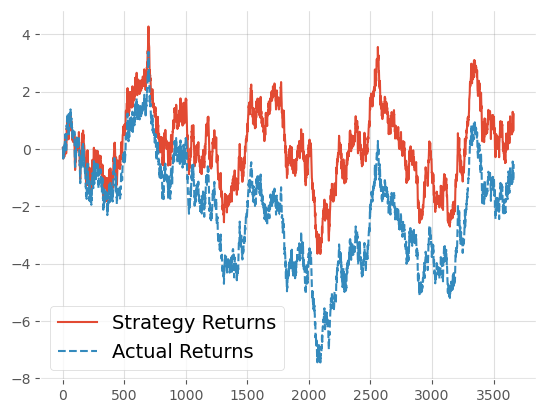

In [152]:
backtestdata_insample[["Strategy Returns","Actual Returns"]].cumsum().hist()
backtestdata_insample[["Strategy Returns","Actual Returns"]].cumsum().plot(style=["-","--"])

In [153]:
backtestdata_insample.sort_values(by='Date', ascending=True).tail()

,Date,Adj Close,pos_pred,pos_actual,Market Returns,Actual Returns,Strategy Returns
564,2022-10-18,5.916552,1.0,1.0,0.259819,0.259819,0.259819
986,2022-10-19,5.909441,1.0,1.0,0.384312,-0.384312,-0.384312
3323,2022-10-24,5.937193,1.0,1.0,0.259847,-0.259847,-0.259847
2117,2022-10-25,5.953036,1.0,1.0,-0.013580,0.013580,0.013580
1095,2022-10-31,5.956381,1.0,1.0,0.059348,-0.059348,-0.059348


In [154]:
sharpe8 = sharperatio(backtestdata_insample['Strategy Returns'])
sharpe8

0.034413870909762084

In [155]:
backtestdata_insample['CURET'] = backtestdata_insample['Strategy Returns'].cumsum()
final_port_value_8 = cap * backtestdata_insample['CURET'].iloc[-1]
D = (backtestdata_insample.index[-1] - backtestdata_insample.index[0])

CAGR8 = (final_port_value_8 / cap) ** (365/D) - 1
CAGR8

0.01908476414051119

In [156]:
backtestdata_insample["CUMULATIVE_RETURNS"] = backtestdata_insample["Strategy Returns"].dropna().cumsum()
backtestdata_insample["MAX_GROSS_PERFORMANCE"] = backtestdata_insample["CUMULATIVE_RETURNS"].cummax()

DRAWDOWN = backtestdata_insample["MAX_GROSS_PERFORMANCE"] - backtestdata_insample["CUMULATIVE_RETURNS"]
MaxDrawdown8 = DRAWDOWN.max()
MaxDrawdown8

7.932975912914732

In [157]:
RemainingCapital8 = final_port_value_8
RemainingCapital8

604457.1419378595

In [158]:
Performance_Tracker.loc[7] = ["ML+RandomForest",sharpe8,CAGR8,MaxDrawdown8,RemainingCapital8]

# Part 3: Best  Performers
<a id="BestPerformance"></a>

## [A: LogisticRegression_lag14](#lag14)
## [B: ML+LogisticRegression](#logreg2)
## [C: Momentum_35_85](#momentum)

In [159]:
Performance_Tracker.sort_values(by=["RemainingCapital"], ascending=False)

,StrategyName,SharpeRatio,CAGR,MaxDrawdown,RemainingCapital
5,LogisticRegression_lag14,0.738071,0.151816,2.924634,7.716963e+06
6,ML+LogisticRegression,0.265239,0.249050,7.239367,4.658108e+06
0,SPYBuyandHold,0.554807,0.111847,2.037440,3.753647e+06
2,Momentum_35_85,0.205237,0.040066,0.739178,1.055266e+06
1,MeanReversion_41,0.089425,0.014824,0.633849,6.614316e+05
7,ML+RandomForest,0.034414,0.019085,7.932976,6.044571e+05
3,ML+MeanReversion,0.216028,0.002938,0.114218,5.270916e+05
4,MACD+RF,-0.020629,-0.000846,0.204894,4.924338e+05


# Part 4: Analysis and Recommendations
<a id="Analysis"></a>

From our results we can make the following observations:
1. Not all the machine learning strategies performed equally. Further, it is not clear that the performance of a machine learning strategy improves as more data is input into the model. For example the two models using Logistic Regression performed vastly differently. However - we note that this may be due to the fact that our data in this case was limited to SPY, and the inputs into the machine learning models were merely some variations of the same. Give more varied and independent data, we suspect that the performance of machine learning models may improve further.
2. Given that we were able to use the full dataset for our model training and testing (i.e. there is obvious data leakage) - there is inevitably going to be overfitting. In light of this, most if not all the models cannot be used out-of-sample without retraining/changing the parameters. This applies to non-machine learning models as well as we had optimised the hyperparamters of the models based on the specific SPY time series. In this regard, we would not necessarily recommend using the "best performing" models for live trading.
3. Most of the strategies that underperformed the benchmark also had significantly smaller drawdowns. This has important implications for portfolio construction. There are certain classes of investors whose main objective may not be to maximise CAGR/Sharpe Ratios, and instead prioritise capital preservation. In particular, investors who must make regular and consistent withdrawals - like retirees or pension funds - may not be able to sustain large drawdowns in their portfolios.

Recommendations:
1. DO NOT USE ANY OF THESE MODELS FOR LIVE TRADING (See point 2 above).
2. Request for more varied data to train the machine learning models.
3. Buy and hold the index.

# Part 5: Contribution Statement
<a id="Contribution"></a>

All group members attempted the project individually before meeting to compare results and discuss pros and cons of each suggested approach. For completeness, we have highlighted some of the specific contributions to the project below.

1. HE YIHAO

Mean Reversion strategy. General Code debugging.

2. VO VAN QUOC TOAN

Logistic Regression + Machine Learning Strategy. Random Forest Strategy.

3. SEAH YAN DE BRYAN

Logistic Regression Strategy. Compiled the code and wrote this report.

4. CHANG TING YU

Moving Average Crossover Strategy. Momentum + Machine Learning Strategy.

5. QU WENQIN

Mean Reversion + Machine Learning Strategy. MACD + Random Forest Strategy. 